# "A" sessile drop sitting on a superhydrophobic surface

### Essential imports

In [1]:
from numpy import *
from scipy.integrate import solve_ivp
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd

mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'

AxesLabel, TickLabel = [30, 30]
plt.rcParams.update({
    'font.size' : TickLabel,                   # Set font size to 11pt
    'axes.labelsize': AxesLabel,               # -> axis labels
    'legend.fontsize': AxesLabel,              # -> legends
    'xtick.labelsize': TickLabel,              # -> x-axis tick labels
    'ytick.labelsize': TickLabel,              # -> y-axis tick labels
})


## Young-Laplace equation

<img src="Schematic.png" 
        alt="Picture" 
        width="600" 
        style="display: block; margin: 0 auto" />

Laplace equaiton for this problem gives a boundary value problem (see figure) where the two boundaries are the surface of the drop and the surface of the substrate. However, both boundaries are not known apriori. Therefore, we will solve the problem using the initial value problem (IVP) formulation.

The set of ODE that we need to solve is the following:

Let us use the gravito-capillary length as the length scale. That is: $L_0 = \sqrt{\gamma/\rho g}$.

$$ \frac{d\phi}{ds} + \frac{\sin\phi}{r} = \kappa_T + z $$

where $r-z$ is the cylindrical coordinate system as shown in the figure. We have parameterized the equation for curvature using the length of arc $s$ and the tangent angle $\phi$. See page 15-16 of [deserno2004notes](https://www.cmu.edu/biolphys/deserno/pdf/diff_geom.pdf) for more details. Consequently, two more ODEs are needed to solve the problem:

$$ \frac{dr}{ds} = \cos\phi $$
$$ \frac{dz}{ds} = \sin\phi $$

### Initial conditions

$$ \phi(s = 0) = 0 $$
$$ r(s = 0) = 0 $$ 

**Note:** Need to initialize with a very small (finite) valuen of $r(s = 0)$ to avoid division by zero.

$$ z(s = 0) = 0 $$

### Volume

Using such a normalization, the volume of the drop is given by:

$$ V = \frac{4\pi}{3}\left(\frac{R_0}{L_0}\right)^3 = \frac{4\pi}{3}\left(Bo\right)^{3/2}$$

Hence, Bond number $Bo$ is

$$ Bo = \left(\frac{3V}{4\pi}\right)^{2/3} $$

If solved in serial, for every $\kappa_T$ (note that $\kappa_T$ is normalized using $L_0^{-1}$), we will get one $Bo$

### References
``` bib
@misc{deserno2004notes,
  title={Notes on differential geometry},
  author={Deserno, M.},
  year={2004},
  publisher={Dover, New York. https://www.cmu.edu/biolphys/deserno/pdf/diff_geom.pdf}
}
```

## Essential functions

### Solution

In [2]:
# Laplace equation for a sessile drop
def LaplaceEqn(t, y, Bo, KappaT):
    Phi = y[0]
    r = y[1]
    z = y[2]

    f0 = Bo*z + KappaT - sin(Phi)/r
    f1 = cos(Phi)
    f2 = sin(Phi)

    return array([f0, f1, f2])

# stop integration when Phi = pi
def event(t, y, Bo, KappaT):
    return y[0] - pi

# calculate the volume of the drop given by (R, Z)
def volume(R, Z):
    return -pi*trapz(R**2, Z)

# calculate the volume of the drop given by (R, Z)
def surface(R, Z, S):
    return 2*pi*trapz(R, S)

# calculate the center of mass of the drop given by (R, Z)
def centerOfMass(R, Z):
    return trapz((R**2)*Z, Z)/trapz(R**2, Z)

# main funtion to get the drop shape
def getDrop(Bo, KappaT):
  # Initial conditions
  Phi0, r0, z0 = 0.0, 1e-50, 0.0
  y0 = array([Phi0, r0, z0])
  y0.reshape(3,)

  # parameterizatio is done using the arc length s
  s0, sMax, ds = 0.0, 1e4, 1e-4
  
  event.terminal = True
  return solve_ivp(LaplaceEqn, [s0, sMax], y0, args=(Bo, KappaT), t_eval=arange(s0, sMax, ds), events=event)


### Plotting

In [3]:
def Plotting(R, Z, S, Phi, r, z, filename, Bo, KappaT, Zcm):
    fig, AX = plt.subplots(2, 2)
    fig.patch.set_facecolor('white')
    fig.set_size_inches(20, 15)
    ax1, ax2, ax3, ax4 = AX.flatten()

    ax1.plot(R, Z, 'r-', linewidth=4.0)
    ax1.plot(-R, Z, 'r-', linewidth=4.0)
    ax1.plot(0, Zcm, 'go', markersize=15.0)
    ax1.set_xlabel(r'$\mathcal{R}/\sqrt{\gamma/\rho g}$')
    ax1.set_ylabel(r'$\mathcal{Z}/\sqrt{\gamma/\rho g}$')
    ax1.set_aspect('equal')
    ax1.set_xlim(-1.1*R.max(), 1.1*R.max())
    ax1.set_ylim(0.0, 1.05*Z.max())

    ax2.plot(S, Phi/pi, 'b-', linewidth=4.0)
    ax2.set_xlabel(r'$s/\sqrt{\gamma/\rho g}$')
    ax2.set_ylabel(r'$\phi/\pi$')
    ax2.set_box_aspect(1)
    ax2.set_xlim(0.0, S.max())
    ax2.set_ylim(0.0, 1.05)

    ax3.plot(S, r, 'k-')
    ax3.set_xlabel(r'$s/\sqrt{\gamma/\rho g}$')
    ax3.set_ylabel(r'$r/\sqrt{\gamma/\rho g}$')
    ax3.set_box_aspect(1)
    ax3.set_xlim(0.0, S.max())
    ax3.set_ylim(0.0, 1.05*r.max())

    ax4.plot(S, z, 'k-')
    ax4.set_xlabel(r'$s/\sqrt{\gamma/\rho g}$')
    ax4.set_ylabel(r'$z/\sqrt{\gamma/\rho g}$')
    ax4.set_box_aspect(1)
    ax4.set_xlim(0.0, S.max())
    ax4.set_ylim(0.0, 1.05*z.max())
    # set figure title
    l1, b1, w1, h1 = ax1.get_position().bounds
    l2, b2, w2, h2 = ax2.get_position().bounds

    L = max(b1+h1, b2+h2)
    # set title position
    fig.text(0.5, L+0.025, r'$Bo = %5.4e$, $\kappa_T = %5.4e$' % (Bo, KappaT), fontsize=AxesLabel, ha='center')

    plt.savefig(filename, bbox_inches='tight')
    plt.show()

## Main codes!

### Getting some images to get an idea of the variation of the drop shape

Using a very coarse grid for KappaT and generating images for each value of KappaT

KappaT = 1.0000e-01
------------------------------------
Volume = 8.0037e+01
Perimeter = 8.8506e+00
Surface Area = 1.2025e+02
Bo = 7.1472e+00, H = 2.092, Zcm = 0.890, W = 3.930, Rw = 3.413
------------------------------------


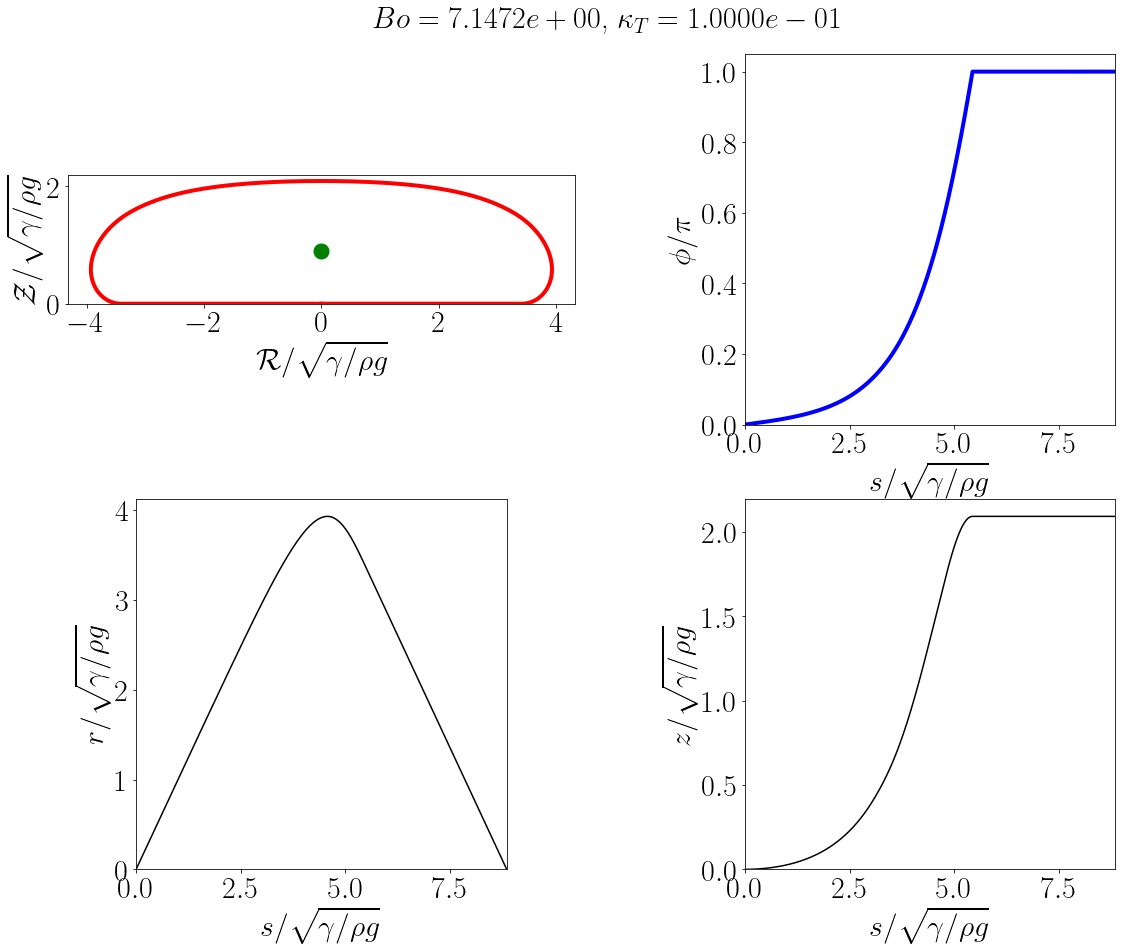

KappaT = 1.1000e+00
------------------------------------
Volume = 7.0013e+00
Perimeter = 3.6224e+00
Surface Area = 1.8782e+01
Bo = 1.4084e+00, H = 1.596, Zcm = 0.681, W = 1.380, Rw = 0.910
------------------------------------


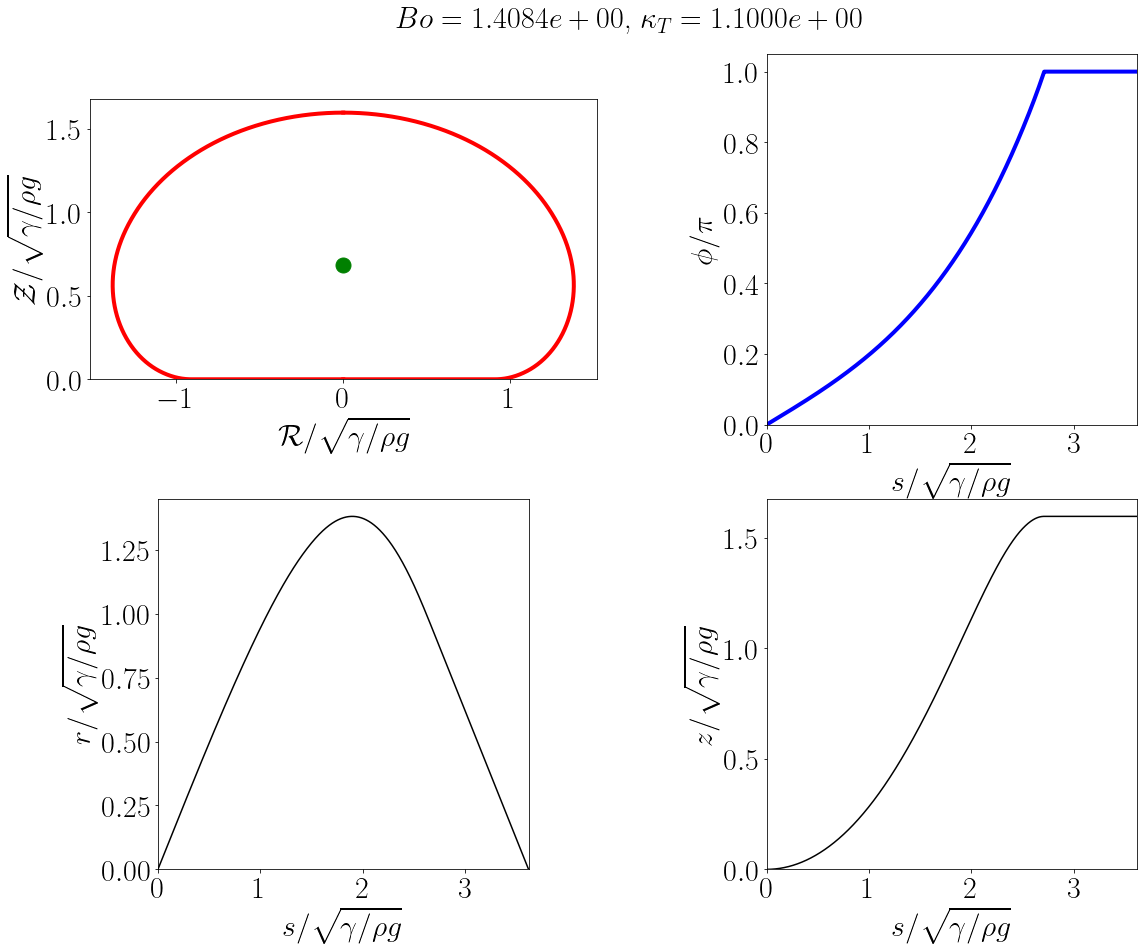

KappaT = 2.1000e+00
------------------------------------
Volume = 2.0278e+00
Perimeter = 2.3989e+00
Surface Area = 7.9107e+00
Bo = 6.1653e-01, H = 1.236, Zcm = 0.549, W = 0.850, Rw = 0.439
------------------------------------


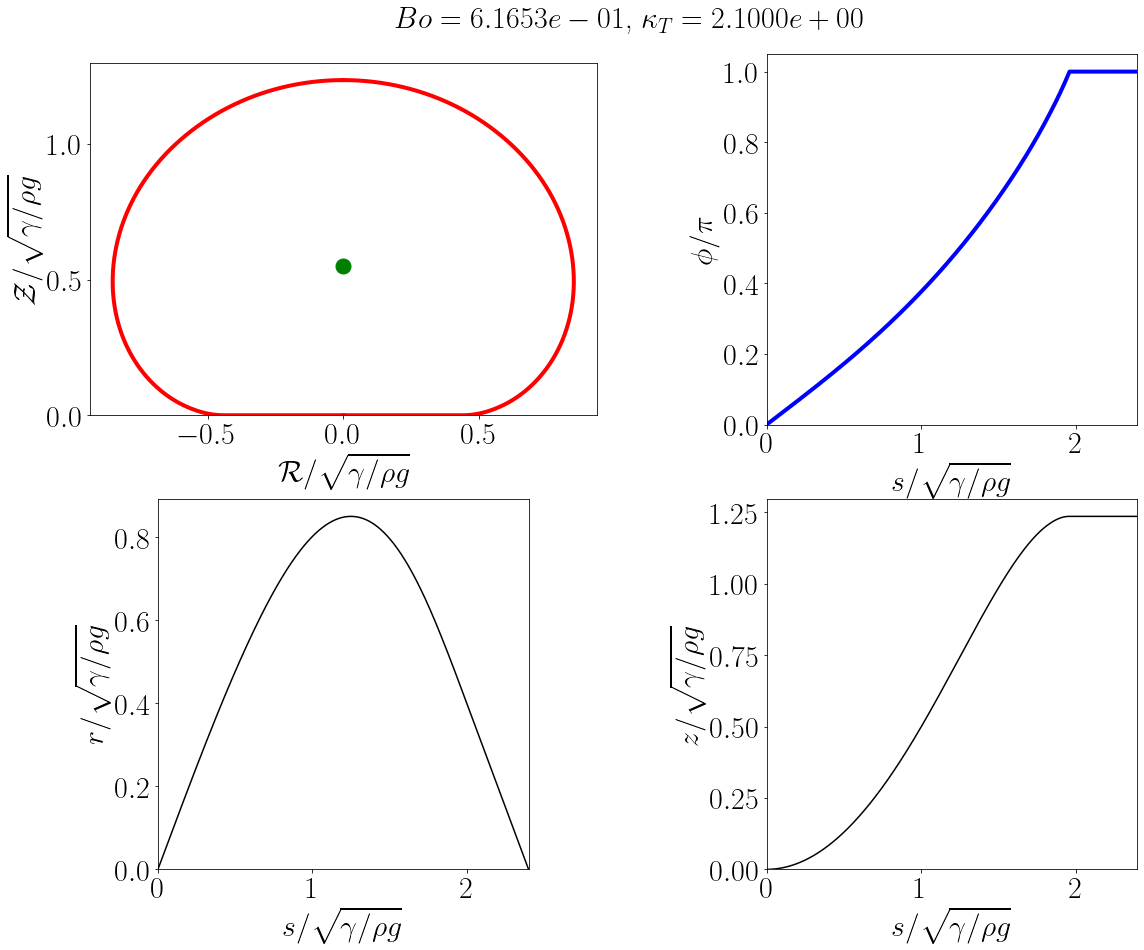

KappaT = 3.1000e+00
------------------------------------
Volume = 8.1515e-01
Perimeter = 1.7794e+00
Surface Area = 4.2555e+00
Bo = 3.3581e-01, H = 0.983, Zcm = 0.448, W = 0.608, Rw = 0.256
------------------------------------


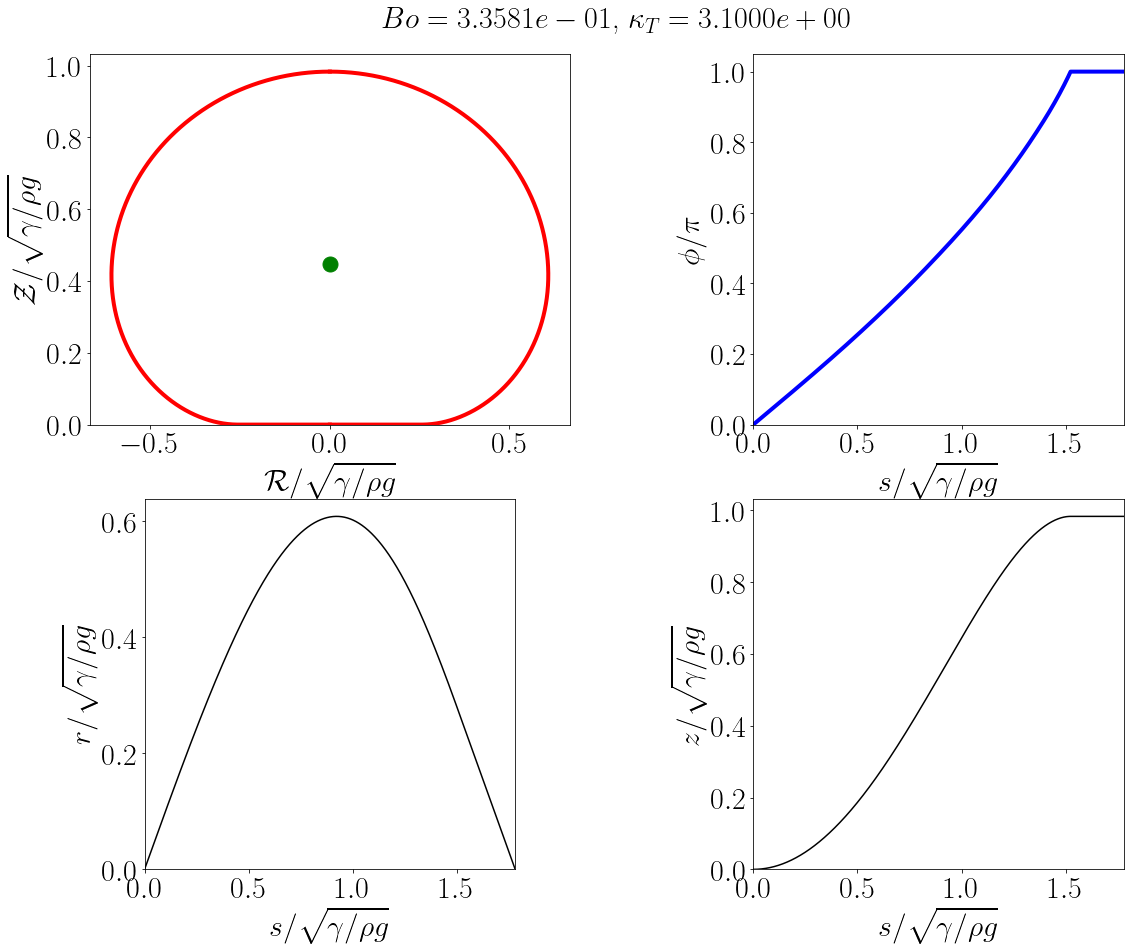

KappaT = 4.1000e+00
------------------------------------
Volume = 3.9759e-01
Perimeter = 1.4080e+00
Surface Area = 2.6241e+00
Bo = 2.0808e-01, H = 0.812, Zcm = 0.379, W = 0.471, Rw = 0.161
------------------------------------


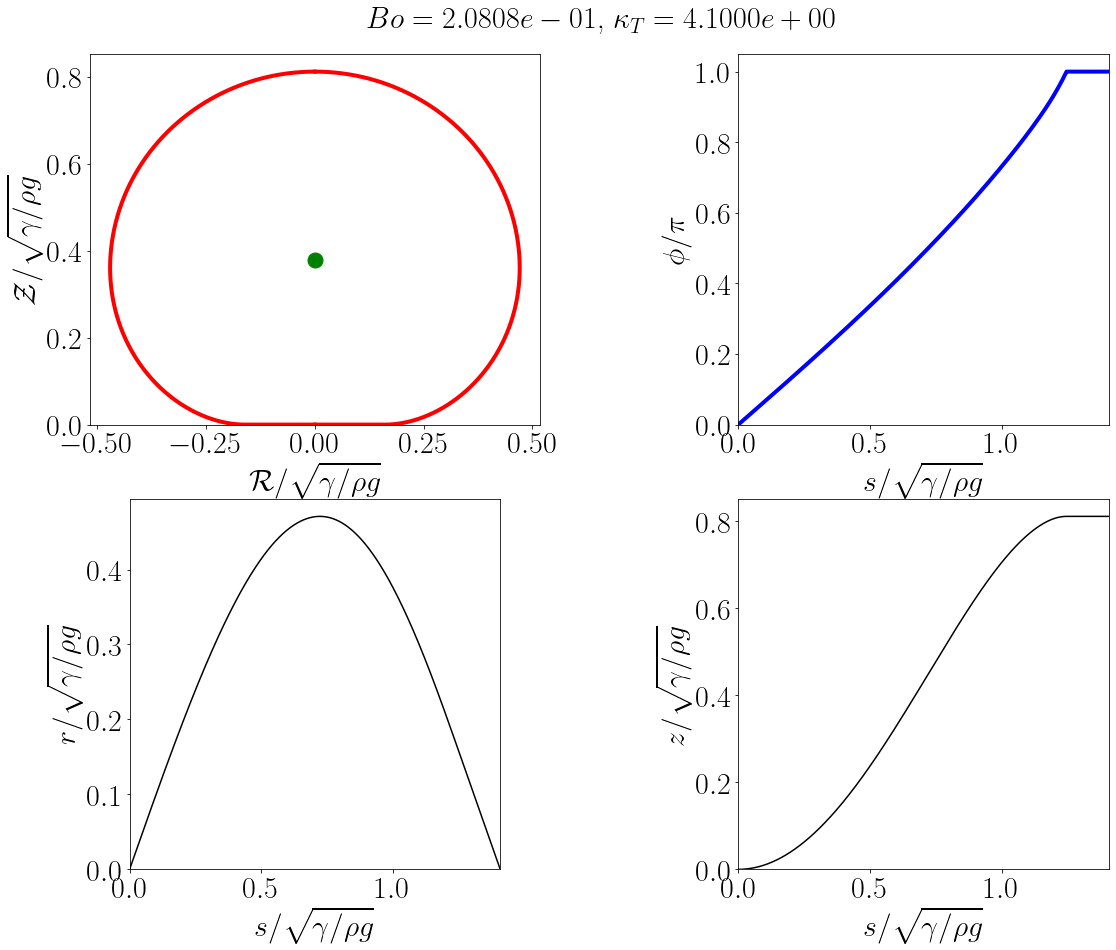

KappaT = 5.1000e+00
------------------------------------
Volume = 2.2046e-01
Perimeter = 1.1612e+00
Surface Area = 1.7674e+00
Bo = 1.4044e-01, H = 0.686, Zcm = 0.325, W = 0.383, Rw = 0.110
------------------------------------


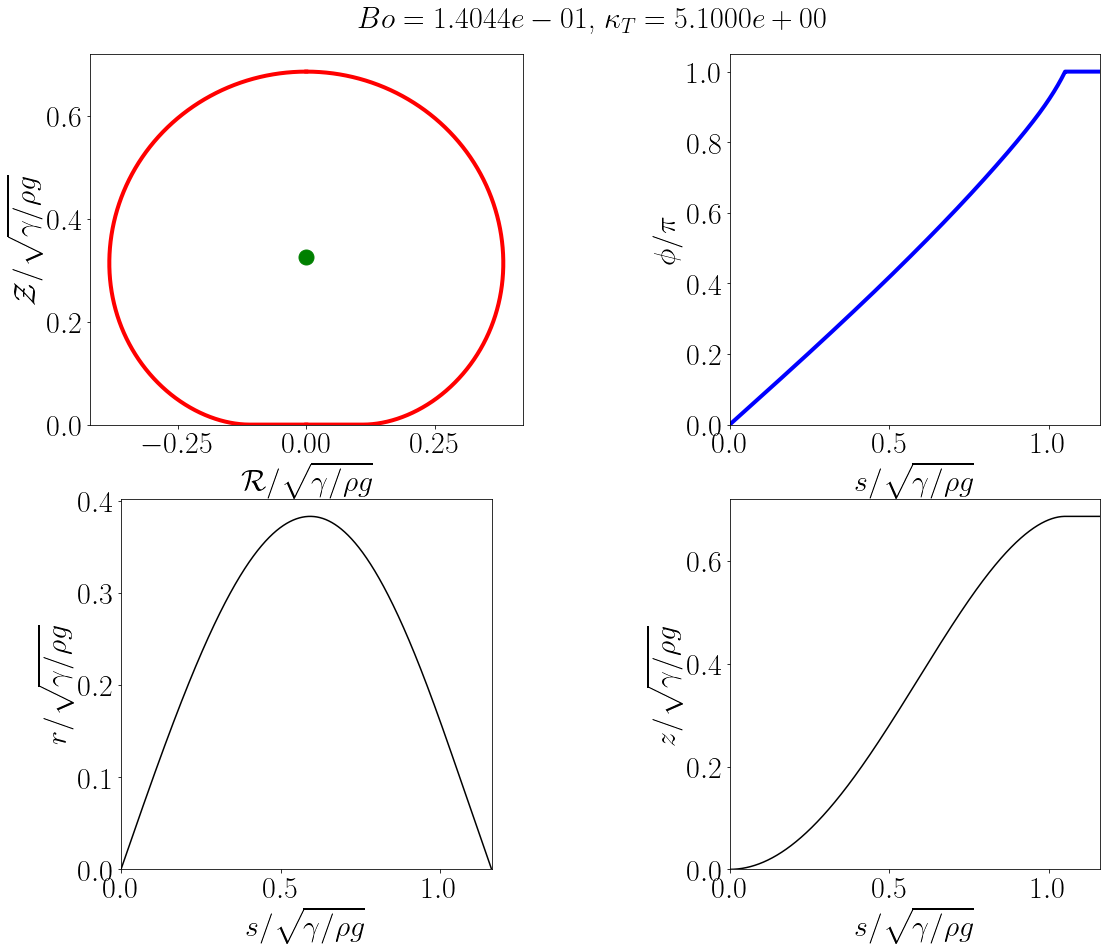

KappaT = 6.1000e+00
------------------------------------
Volume = 1.3391e-01
Perimeter = 9.8609e-01
Surface Area = 1.2663e+00
Bo = 1.0073e-01, H = 0.593, Zcm = 0.284, W = 0.322, Rw = 0.080
------------------------------------


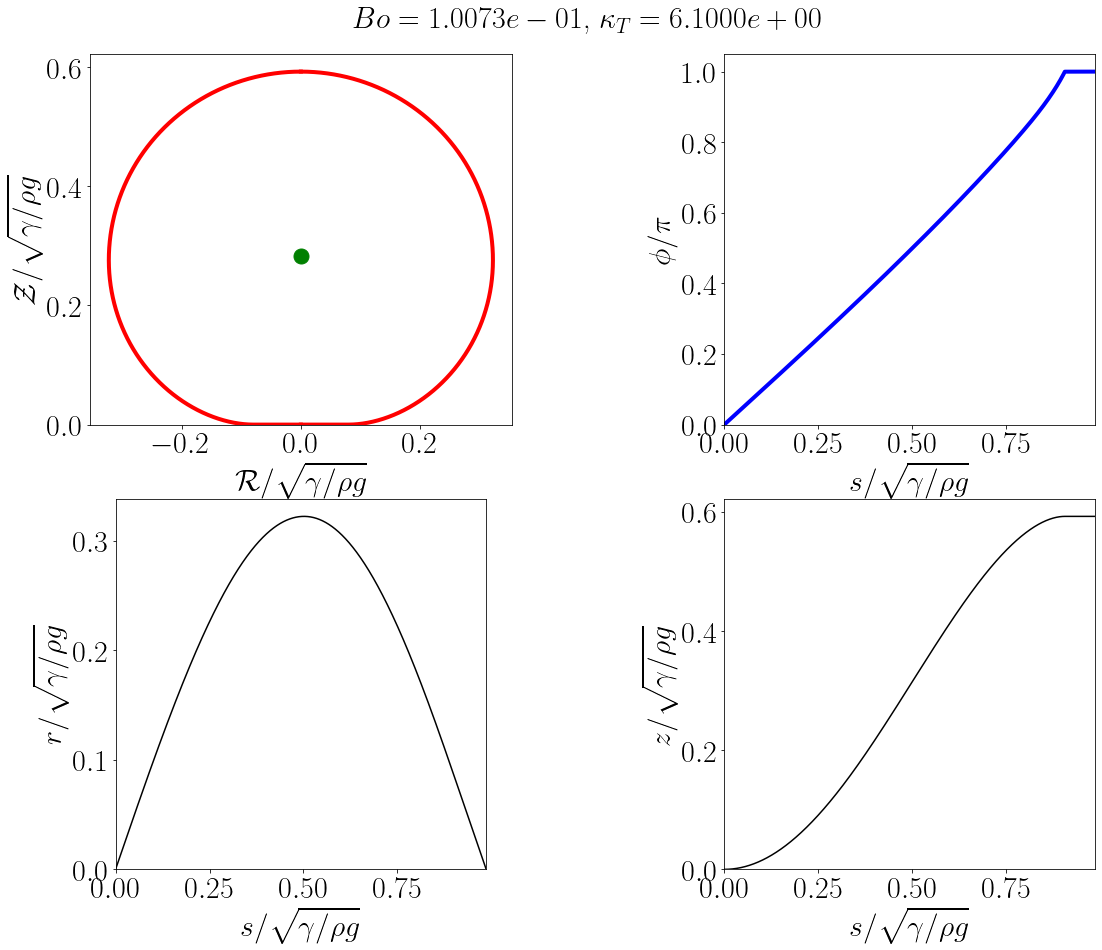

KappaT = 7.1000e+00
------------------------------------
Volume = 8.7045e-02
Perimeter = 8.5589e-01
Surface Area = 9.4965e-01
Bo = 7.5585e-02, H = 0.520, Zcm = 0.251, W = 0.278, Rw = 0.060
------------------------------------


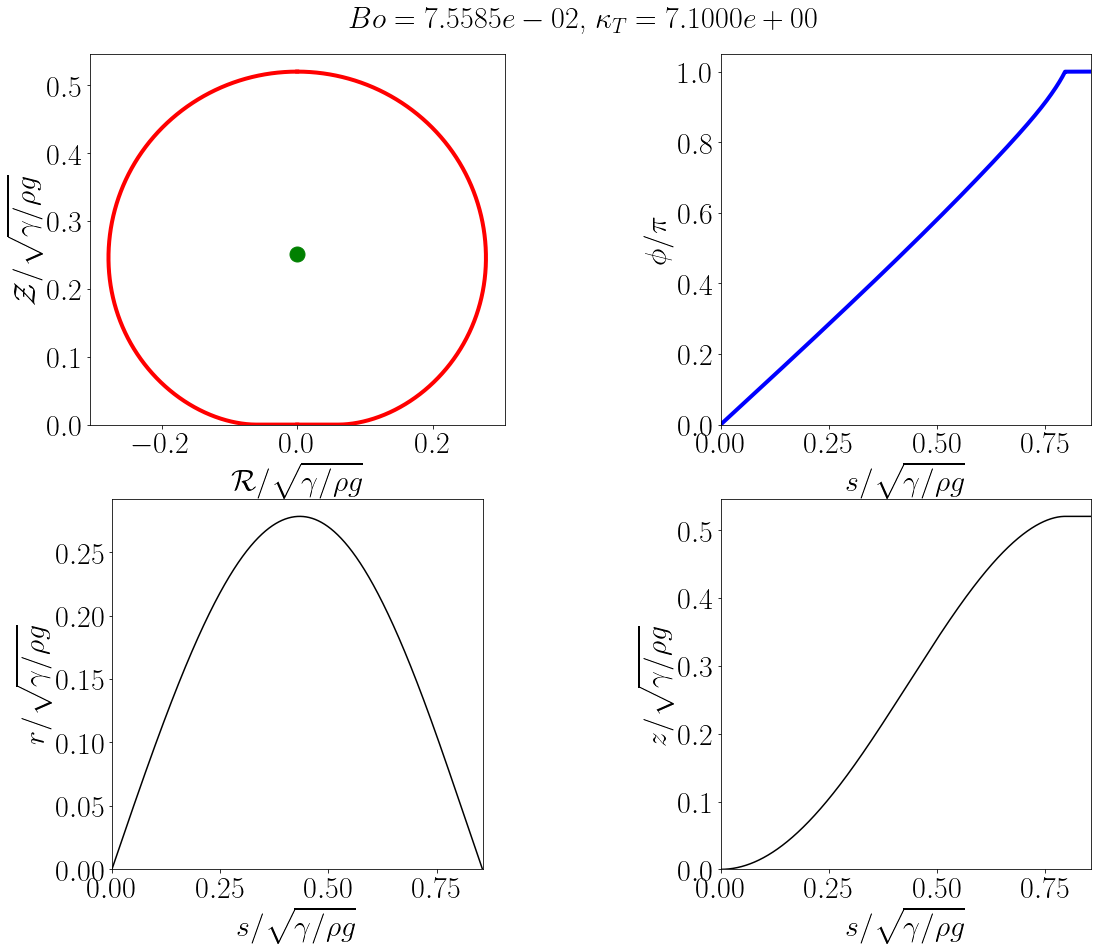

KappaT = 8.1000e+00
------------------------------------
Volume = 5.9604e-02
Perimeter = 7.5549e-01
Surface Area = 7.3751e-01
Bo = 5.8721e-02, H = 0.463, Zcm = 0.225, W = 0.245, Rw = 0.047
------------------------------------


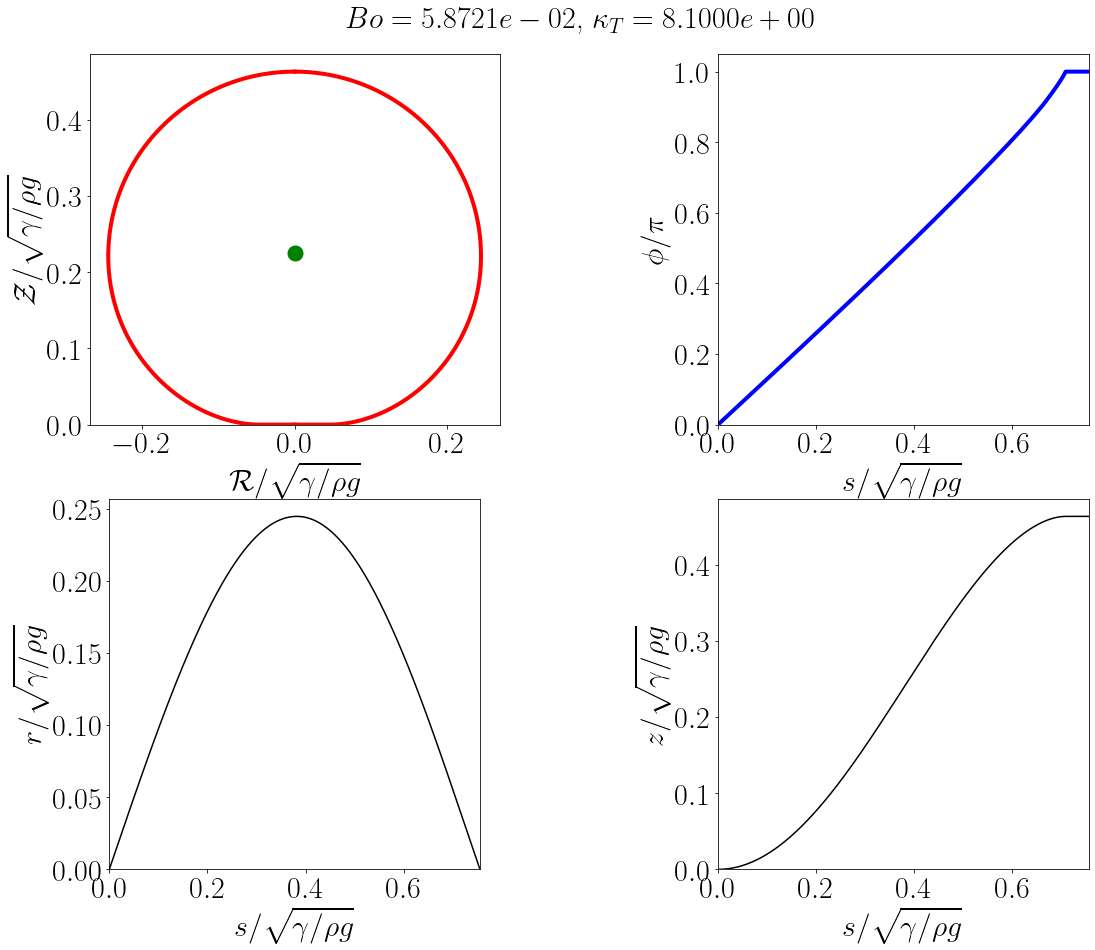

KappaT = 9.1000e+00
------------------------------------
Volume = 4.2529e-02
Perimeter = 6.7586e-01
Surface Area = 5.8878e-01
Bo = 4.6888e-02, H = 0.417, Zcm = 0.203, W = 0.218, Rw = 0.038
------------------------------------


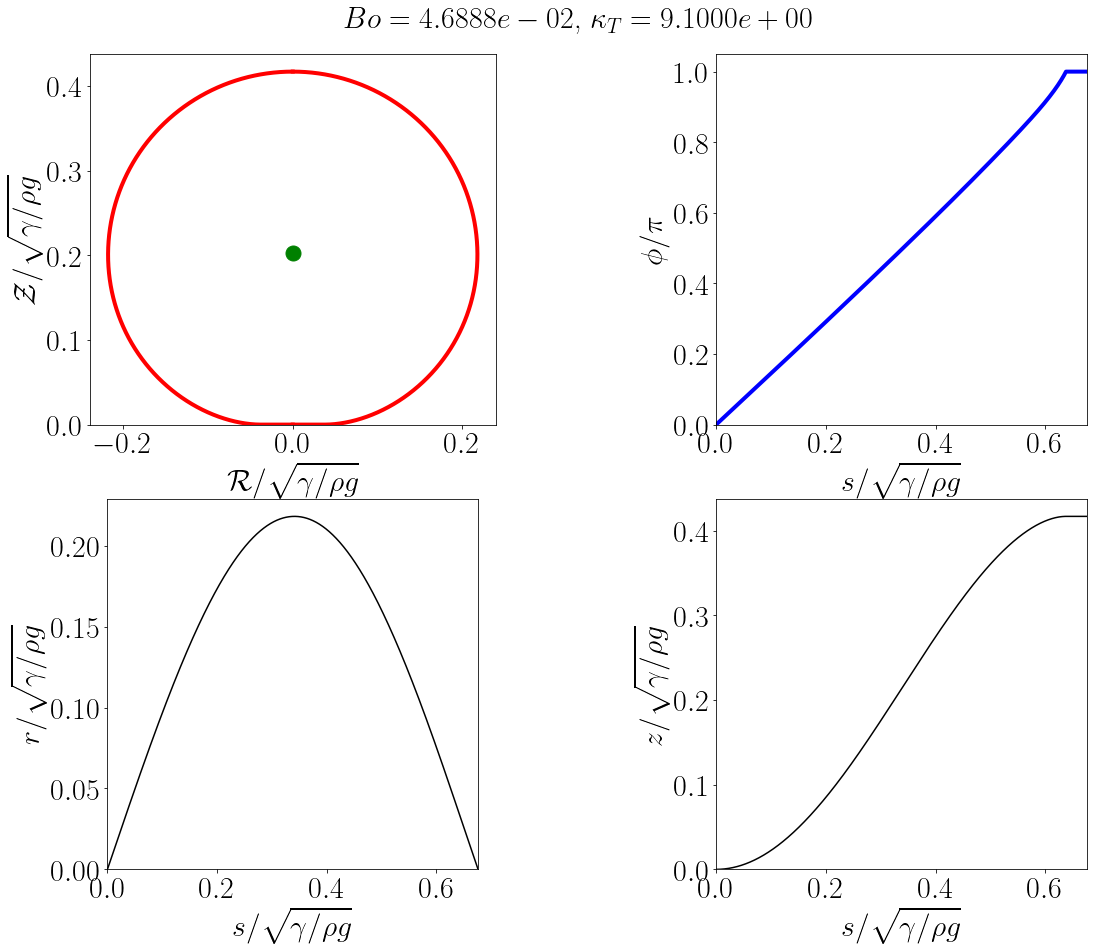

In [4]:
BoNorm = 1.0 # 1 because we normalize using $L_0$ but I did not want to change the function from the previous notebook [SessileDrop.ipynb](SessileDrop.ipynb)
Plot = True
# curvature at the top of the drop: this is the input parameter
# KappaT = arange(1.4707963267949, 2, 1)
KappaT = arange(1e-1, 10.1, 1.0)

Bond = zeros_like(KappaT)
Height = zeros_like(KappaT)
Zcm = zeros_like(KappaT)
Width = zeros_like(KappaT)
Rfoot = zeros_like(KappaT)
Perimeter = zeros_like(KappaT)
SurfaceArea = zeros_like(KappaT)

folder='NormalizeBond'
if not os.path.exists(folder):
    os.makedirs(folder)

for kappa in KappaT:
    print('KappaT = %5.4e' % kappa)
    sol = getDrop(BoNorm, kappa)
    S, Phi, r, z = sol.t, sol.y[0], sol.y[1], sol.y[2]
    # coordinate transformation to have drop straight up
    Z = -z+z[-1]
    R = r
    Rfoot[where(KappaT==kappa)] = R[-1]
    
    # join a straight line from the last point to the origin
    Z = append(Z, 0.0)
    R = append(R, 0.0)
    S = append(S, S[-1]+r[-1])
    r = append(r, 0.0)
    z = append(z, z[-1])
    Phi = append(Phi, pi)

    # width and height of the drop
    Height[where(KappaT==kappa)] = Z.max()
    Width[where(KappaT==kappa)] = R.max()
    # center of mass
    Zcm[where(KappaT==kappa)] = centerOfMass(R, Z)
    # Volume of the drop
    Vol = volume(R, Z)        
    # Perimeter of the drop
    Perimeter[where(KappaT==kappa)] = S[-1]
    # Surface area of the drop
    SurfaceArea[where(KappaT==kappa)] = surface(R, Z, S)
    print('------------------------------------')
    print('Volume = %5.4e' % Vol)
    print('Perimeter = %5.4e' % Perimeter[where(KappaT==kappa)])
    print('Surface Area = %5.4e' % SurfaceArea[where(KappaT==kappa)])

    # the actual Bond number
    BoTrue = (3*Vol/(4*pi))**(2.0/3.0)
    Bond[where(KappaT==kappa)] = BoTrue

    print('Bo = %5.4e, H = %4.3f, Zcm = %4.3f, W = %4.3f, Rw = %4.3f' % (BoTrue, float(Height[where(KappaT==kappa)]), float(Zcm[where(KappaT==kappa)]), float(Width[where(KappaT==kappa)]), float(Rfoot[where(KappaT==kappa)])))
    print('------------------------------------')


    if Plot:
        filename = 'NormalizeBond/NormalizeBond_KappaT_%5.4f_Bond_%5.4f.pdf' % (kappa, BoTrue)
        Plotting(R, Z, S, Phi, r, z, filename, BoTrue, kappa, Zcm[where(KappaT==kappa)])

For very small values of KappaT, the drop is almost flat. As KappaT increases, the drop becomes more spherical. For very large values of KappaT, the drop becomes a sphere.

Note that: $\tilde{\kappa_T} = \kappa_T\sqrt{\gamma/\rho g}$, i.e., it is normalized by the gravito-capillary length (throughout the code, tilde is dropped for simplicity)

In principle, 

$$ \tilde{\kappa_T} = \kappa_T\sqrt{\frac{\gamma}{\rho g}} = \frac{\kappa_TR_0}{\sqrt{Bo}} $$
$$ \kappa_TR_0 = \tilde{\kappa_T}\sqrt{Bo} $$



### Finer run

Now, we make the KappaT grid finer but do not make too many plots to speed up the process.

KappaT = 1.0000e-30
------------------------------------
Volume = 5.7588e+05
Perimeter = 6.0607e+02
Surface Area = 5.7699e+05
Bo = 2.6638e+03, H = 2.009, Zcm = 1.002, W = 302.568, Rw = 302.037
------------------------------------
KappaT = 1.0000e-25
------------------------------------
Volume = 1.5909e+05
Perimeter = 3.1941e+02
Surface Area = 1.6026e+05
Bo = 1.1299e+03, H = 2.010, Zcm = 1.001, W = 159.238, Rw = 158.706
------------------------------------
KappaT = 1.0000e-20
------------------------------------
Volume = 1.0475e+05
Perimeter = 2.5912e+02
Surface Area = 1.0547e+05
Bo = 8.5514e+02, H = 2.017, Zcm = 1.003, W = 129.094, Rw = 128.563
------------------------------------
KappaT = 1.0000e-15
------------------------------------
Volume = 1.4309e+04
Perimeter = 9.6950e+01
Surface Area = 1.4762e+04
Bo = 2.2682e+02, H = 2.021, Zcm = 0.996, W = 48.004, Rw = 47.473
------------------------------------
KappaT = 1.0000e-10
------------------------------------
Volume = 4.6543e+03
Perim

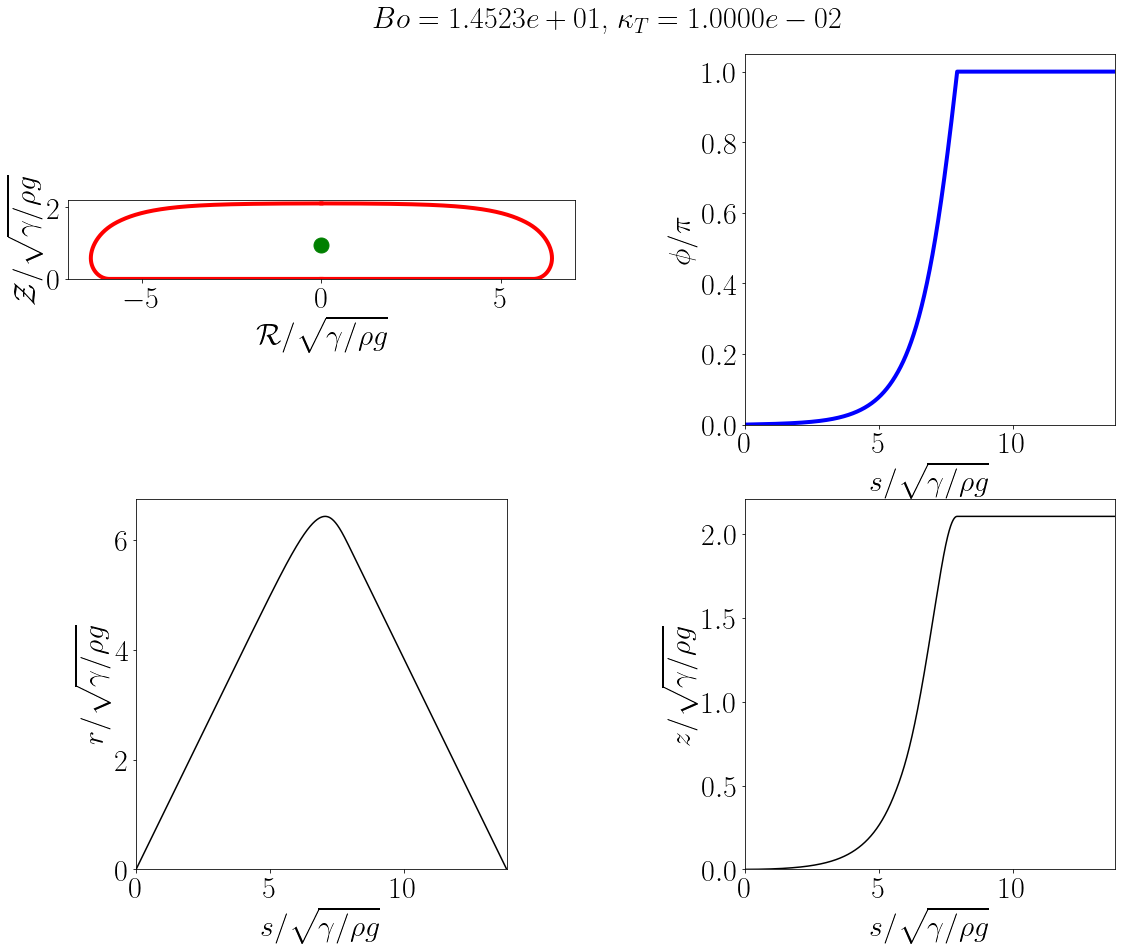

KappaT = 3.1623e-02
------------------------------------
Volume = 1.4625e+02
Perimeter = 1.1343e+01
Surface Area = 1.9943e+02
Bo = 1.0683e+01, H = 2.109, Zcm = 0.921, W = 5.184, Rw = 4.649
------------------------------------


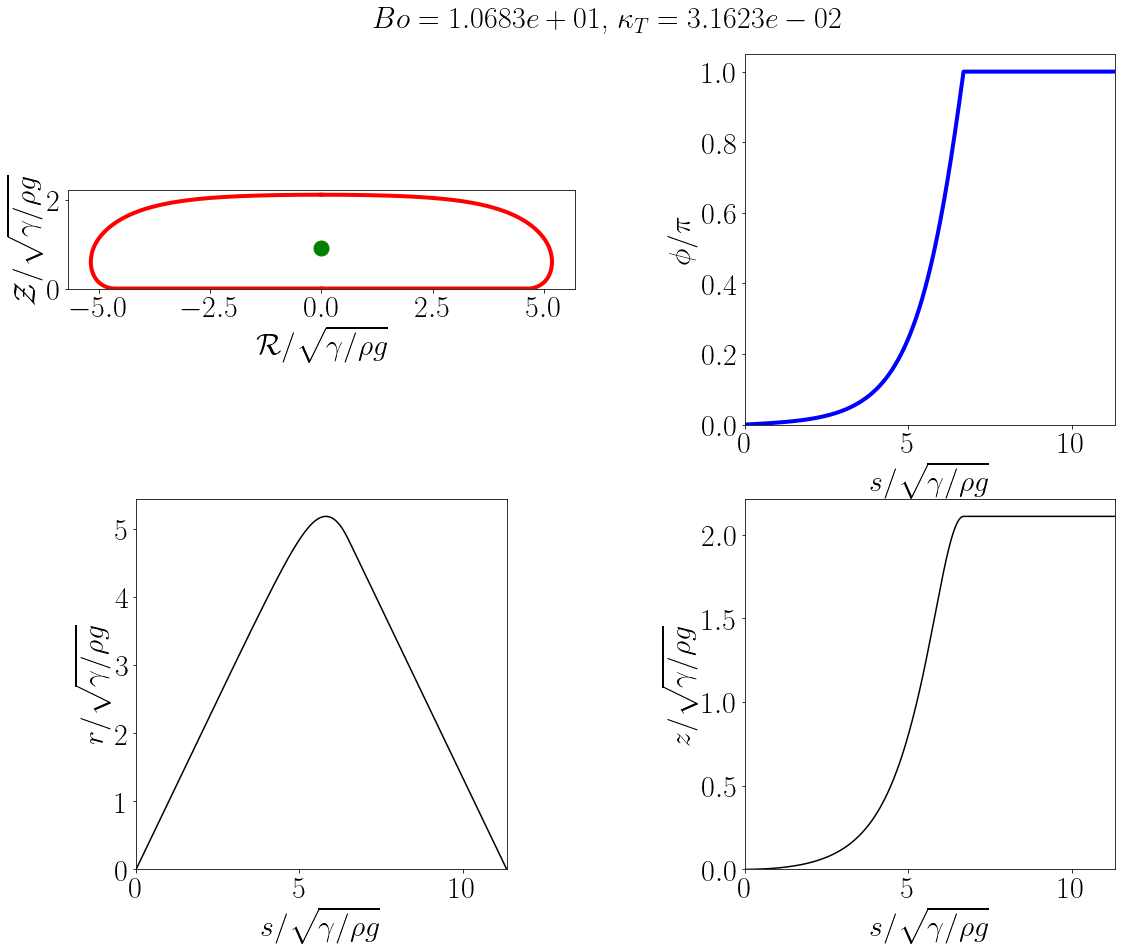

KappaT = 3.9811e-02
------------------------------------
Volume = 1.3159e+02
Perimeter = 1.0850e+01
Surface Area = 1.8221e+02
Bo = 9.9559e+00, H = 2.110, Zcm = 0.917, W = 4.936, Rw = 4.405
------------------------------------


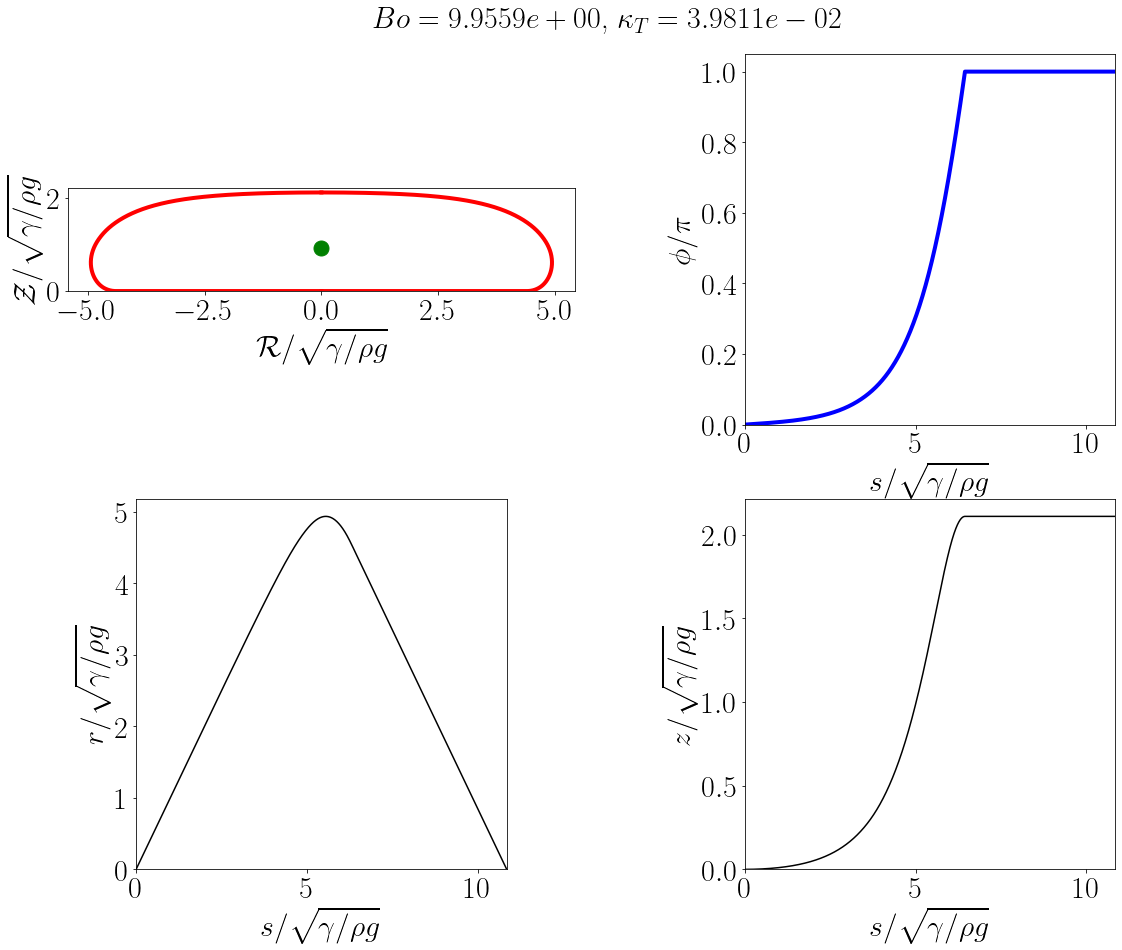

KappaT = 5.0119e-02
------------------------------------
Volume = 1.1750e+02
Perimeter = 1.0353e+01
Surface Area = 1.6563e+02
Bo = 9.2323e+00, H = 2.108, Zcm = 0.912, W = 4.688, Rw = 4.158
------------------------------------


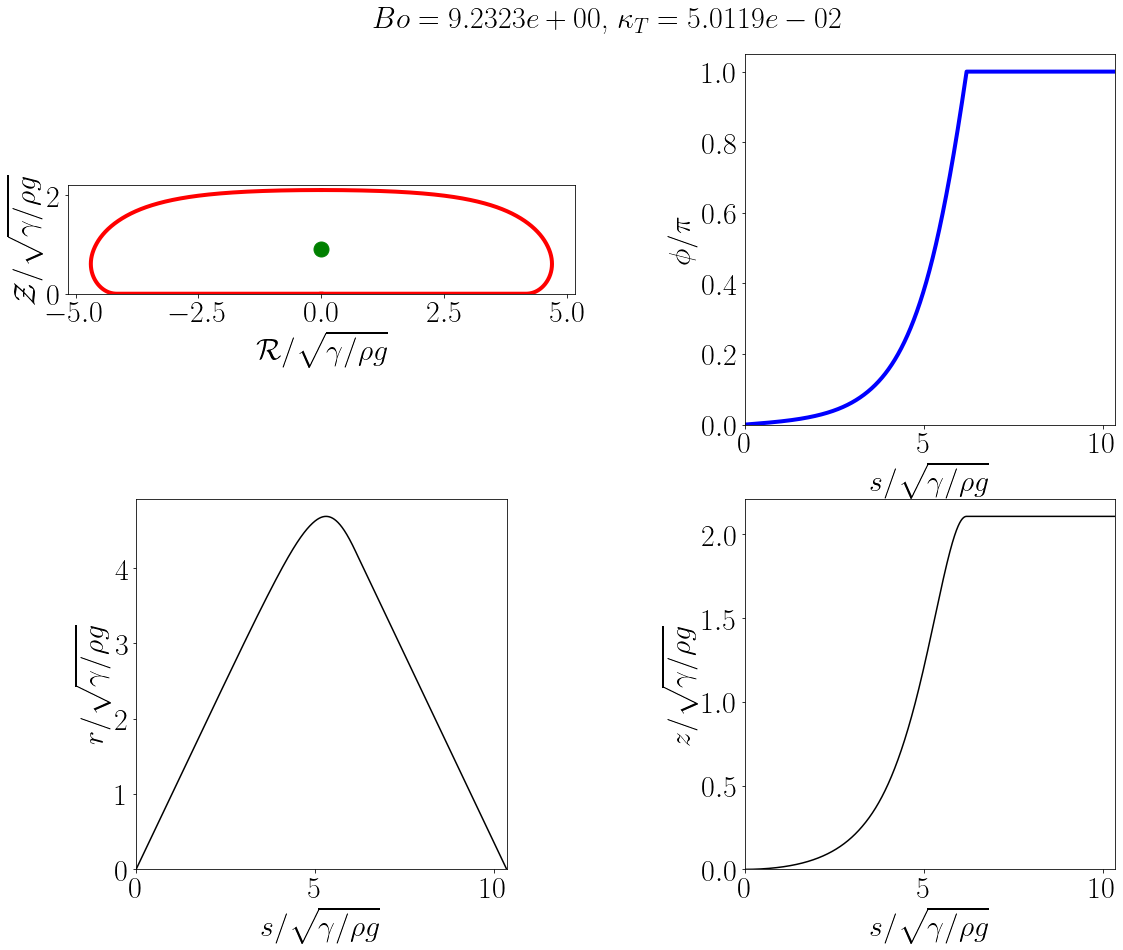

KappaT = 6.3096e-02
------------------------------------
Volume = 1.0417e+02
Perimeter = 9.8522e+00
Surface Area = 1.4974e+02
Bo = 8.5199e+00, H = 2.104, Zcm = 0.905, W = 4.438, Rw = 3.908
------------------------------------


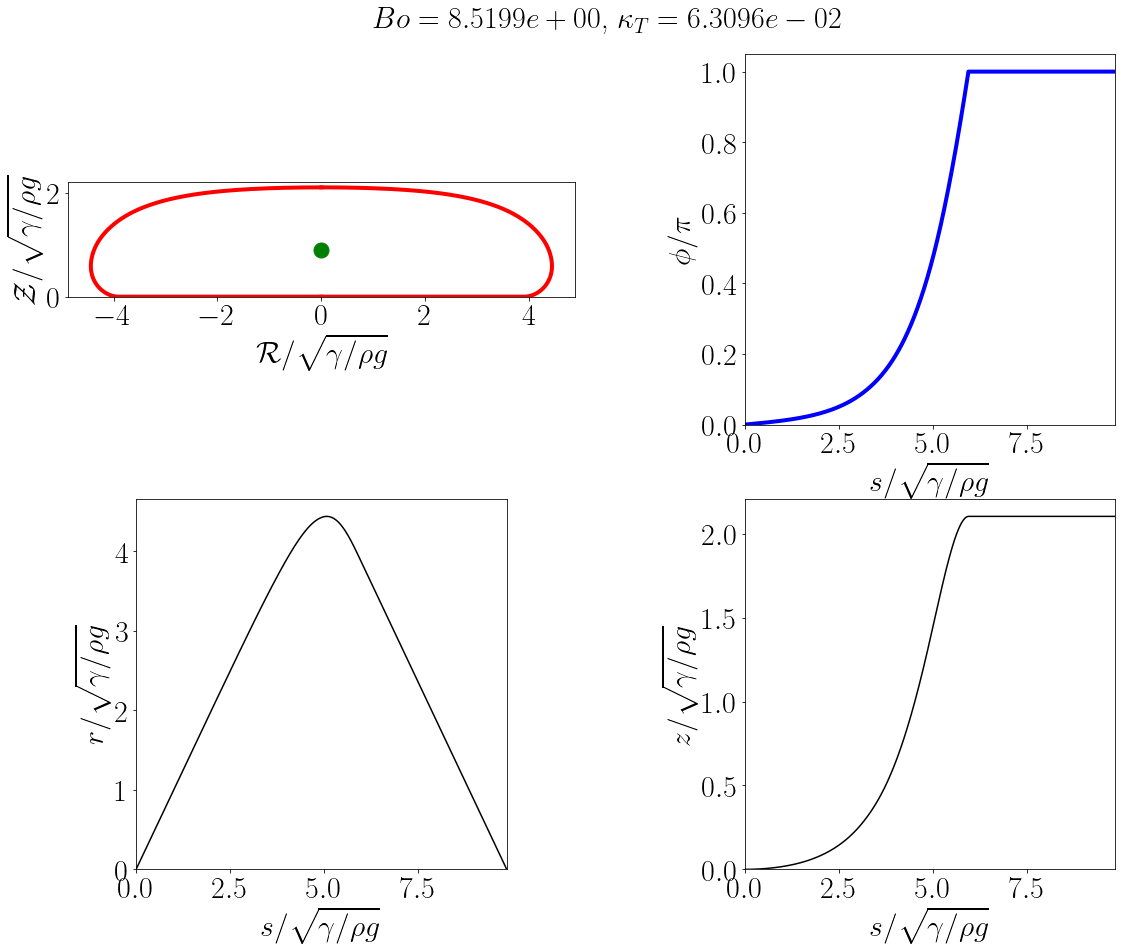

KappaT = 7.9433e-02
------------------------------------
Volume = 9.1530e+01
Perimeter = 9.3529e+00
Surface Area = 1.3465e+02
Bo = 7.8160e+00, H = 2.094, Zcm = 0.896, W = 4.184, Rw = 3.662
------------------------------------


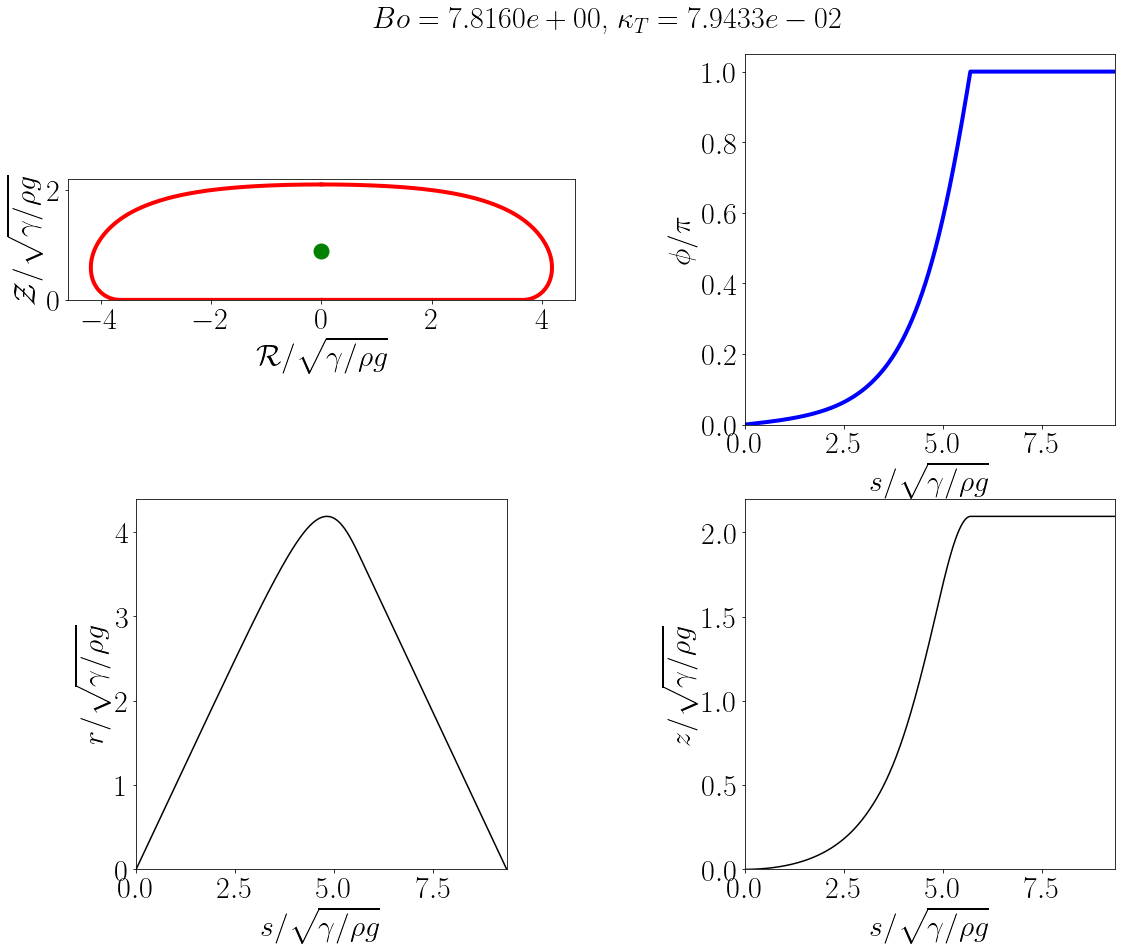

KappaT = 1.0000e-01
------------------------------------
Volume = 8.0037e+01
Perimeter = 8.8506e+00
Surface Area = 1.2025e+02
Bo = 7.1472e+00, H = 2.092, Zcm = 0.890, W = 3.930, Rw = 3.413
------------------------------------


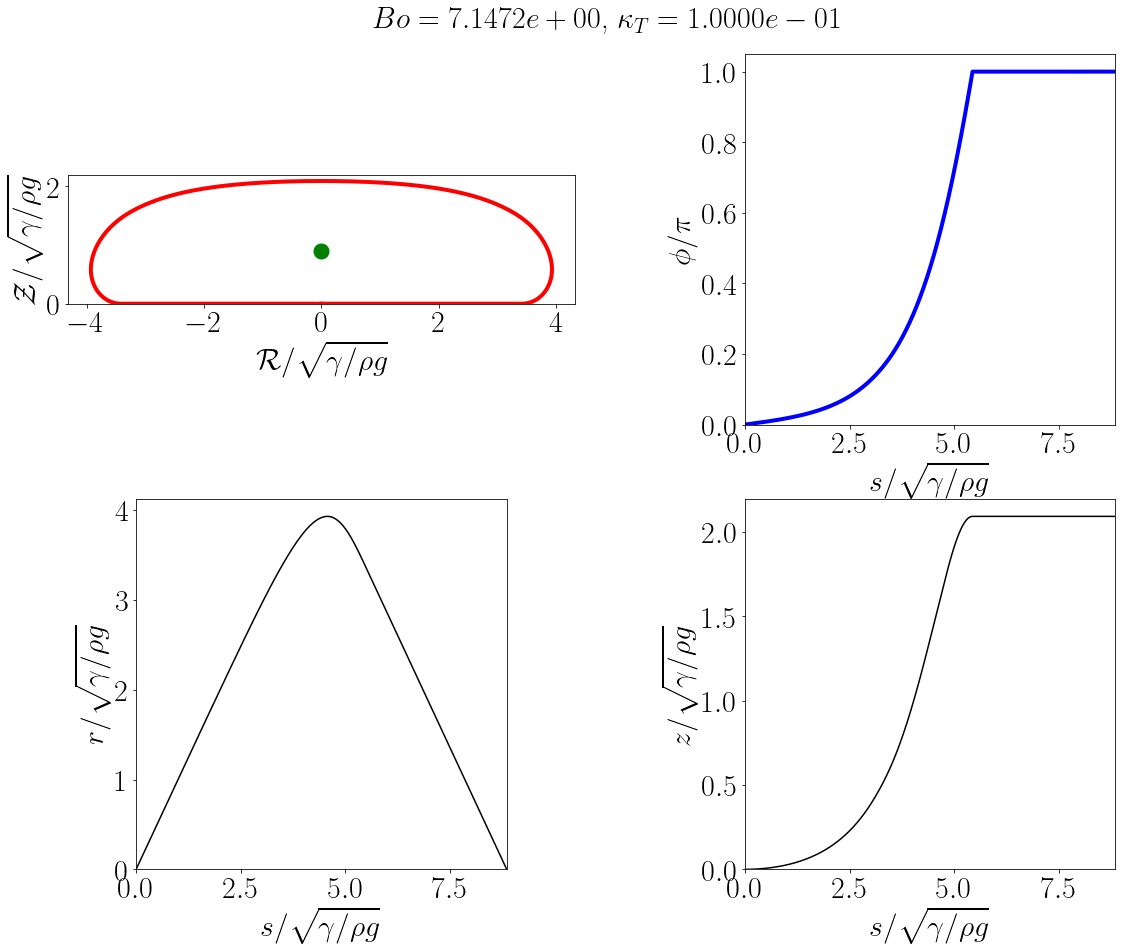

KappaT = 1.2589e-01
------------------------------------
Volume = 6.9030e+01
Perimeter = 8.3433e+00
Surface Area = 1.0656e+02
Bo = 6.4759e+00, H = 2.079, Zcm = 0.881, W = 3.675, Rw = 3.159
------------------------------------


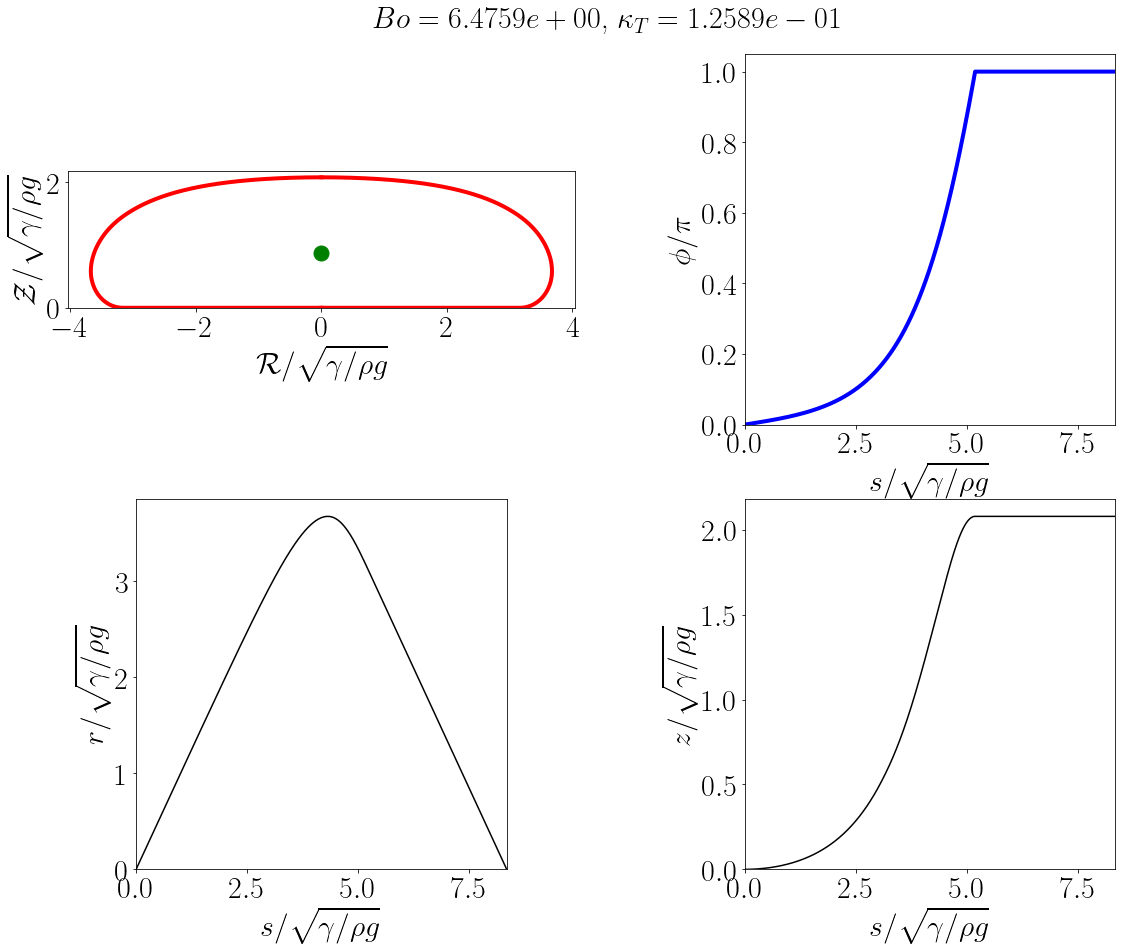

KappaT = 1.5849e-01
------------------------------------
Volume = 5.8968e+01
Perimeter = 7.8327e+00
Surface Area = 9.3614e+01
Bo = 5.8303e+00, H = 2.067, Zcm = 0.872, W = 3.419, Rw = 2.903
------------------------------------


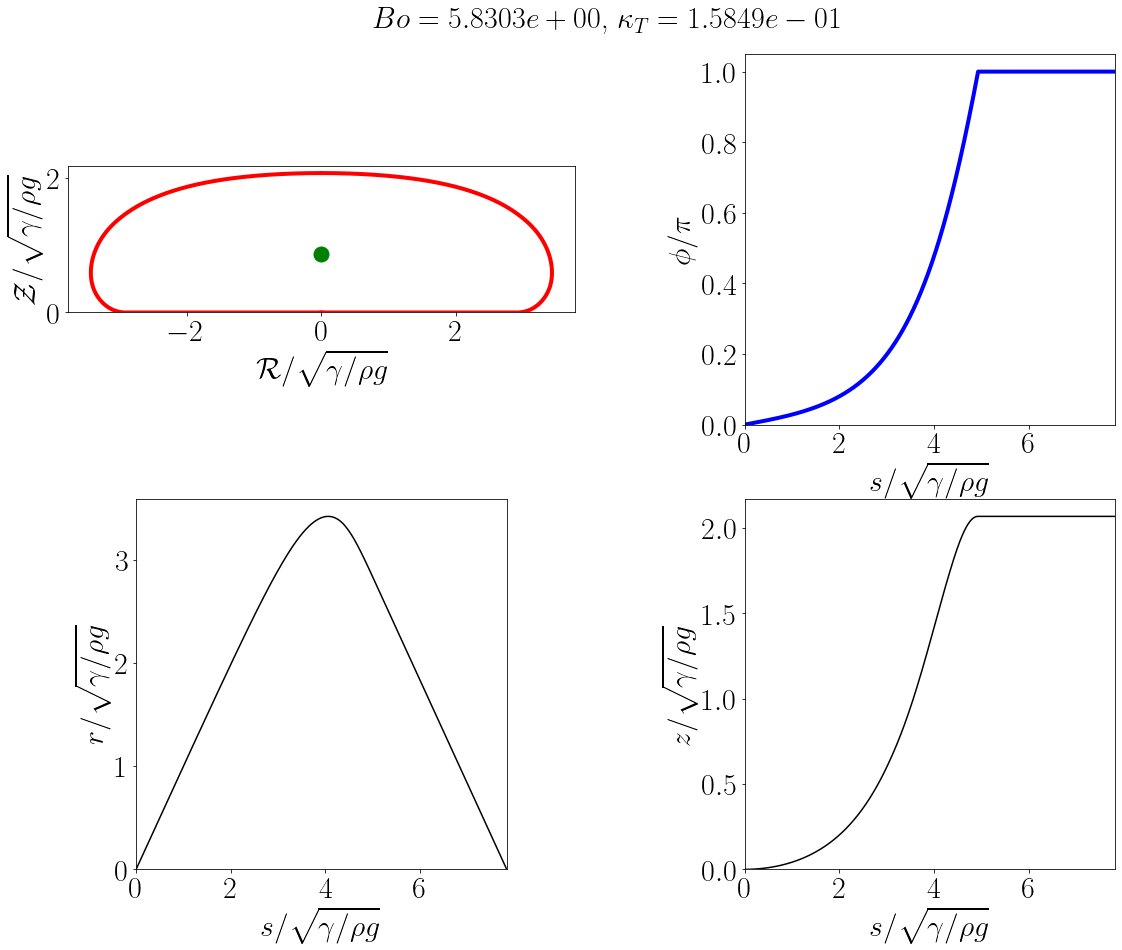

KappaT = 1.9953e-01
------------------------------------
Volume = 4.9649e+01
Perimeter = 7.3200e+00
Surface Area = 8.1462e+01
Bo = 5.1985e+00, H = 2.048, Zcm = 0.861, W = 3.164, Rw = 2.646
------------------------------------


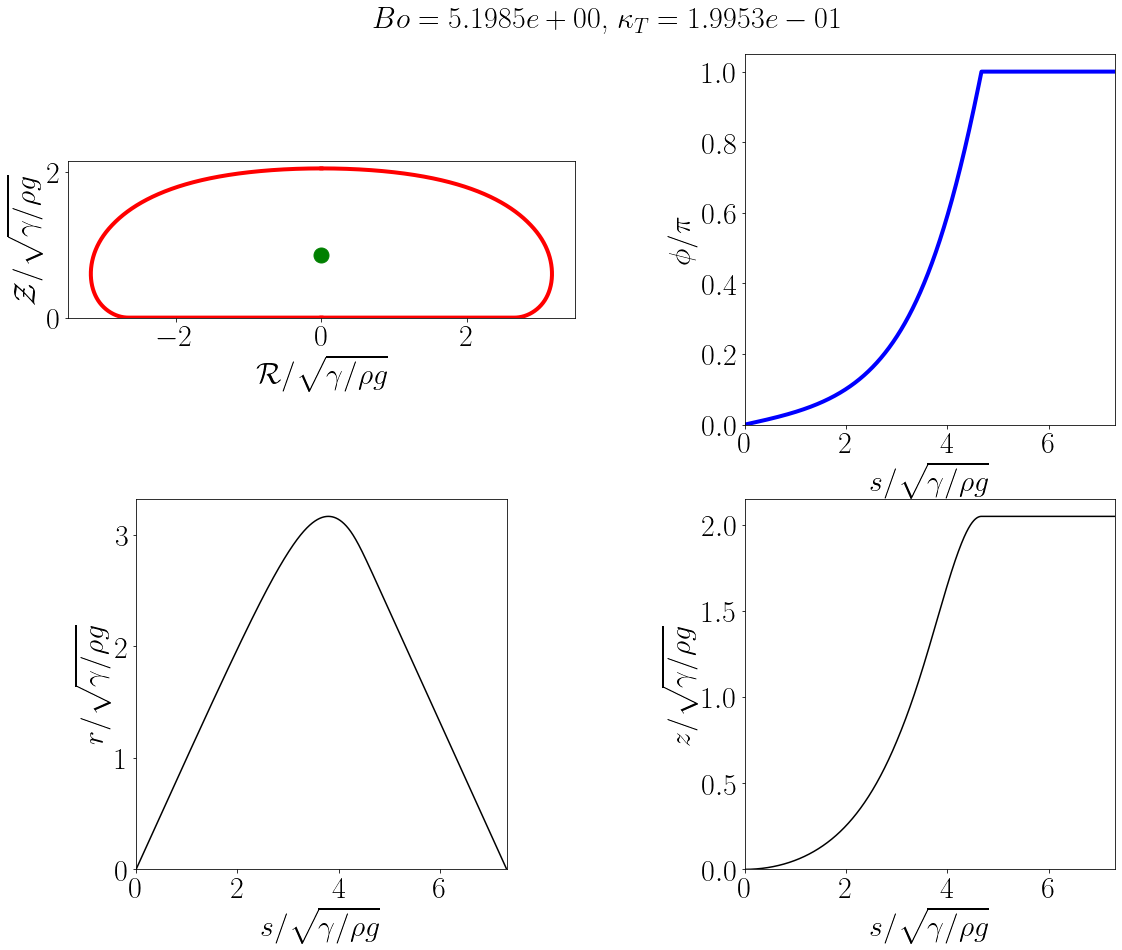

KappaT = 2.5119e-01
------------------------------------
Volume = 4.1110e+01
Perimeter = 6.8094e+00
Surface Area = 7.0185e+01
Bo = 4.5839e+00, H = 2.019, Zcm = 0.846, W = 2.914, Rw = 2.393
------------------------------------


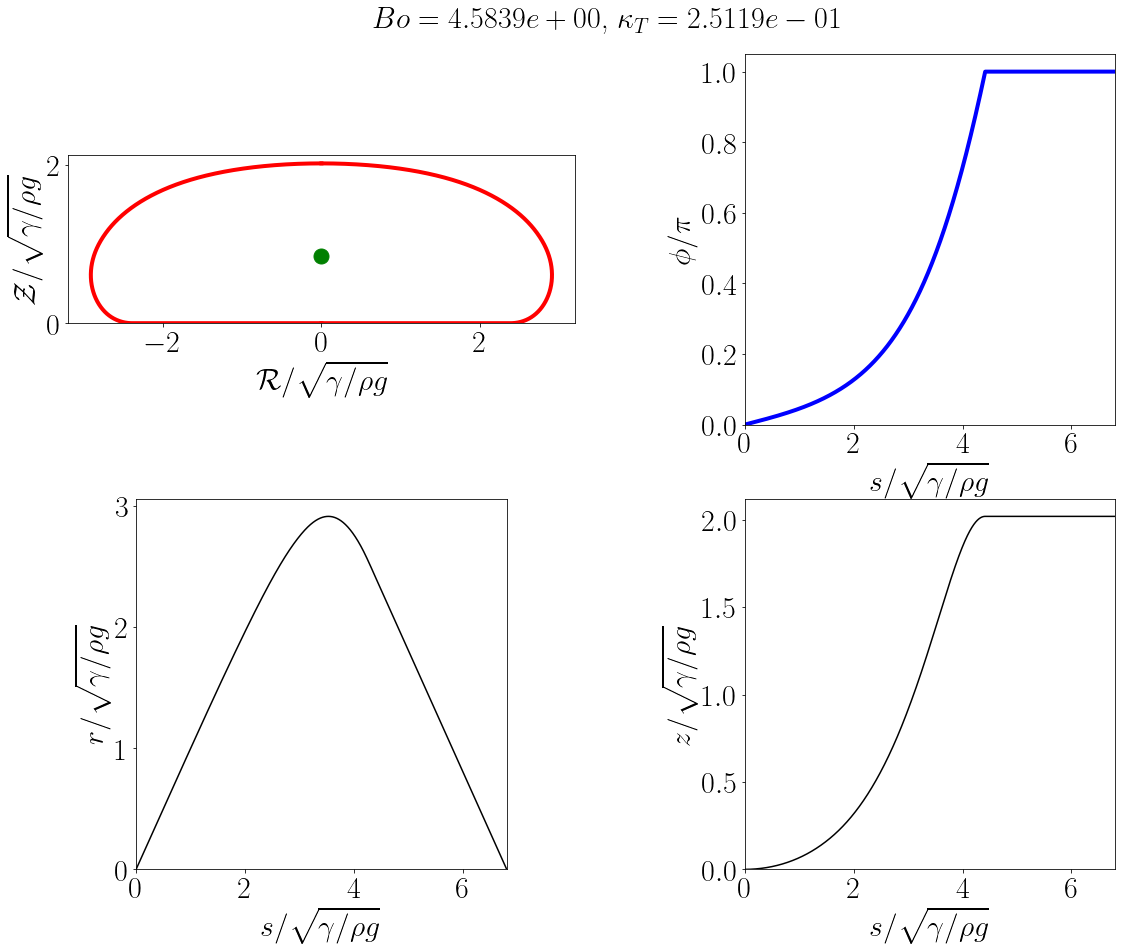

KappaT = 3.1623e-01
------------------------------------
Volume = 3.3445e+01
Perimeter = 6.3045e+00
Surface Area = 5.9828e+01
Bo = 3.9948e+00, H = 1.982, Zcm = 0.829, W = 2.665, Rw = 2.149
------------------------------------


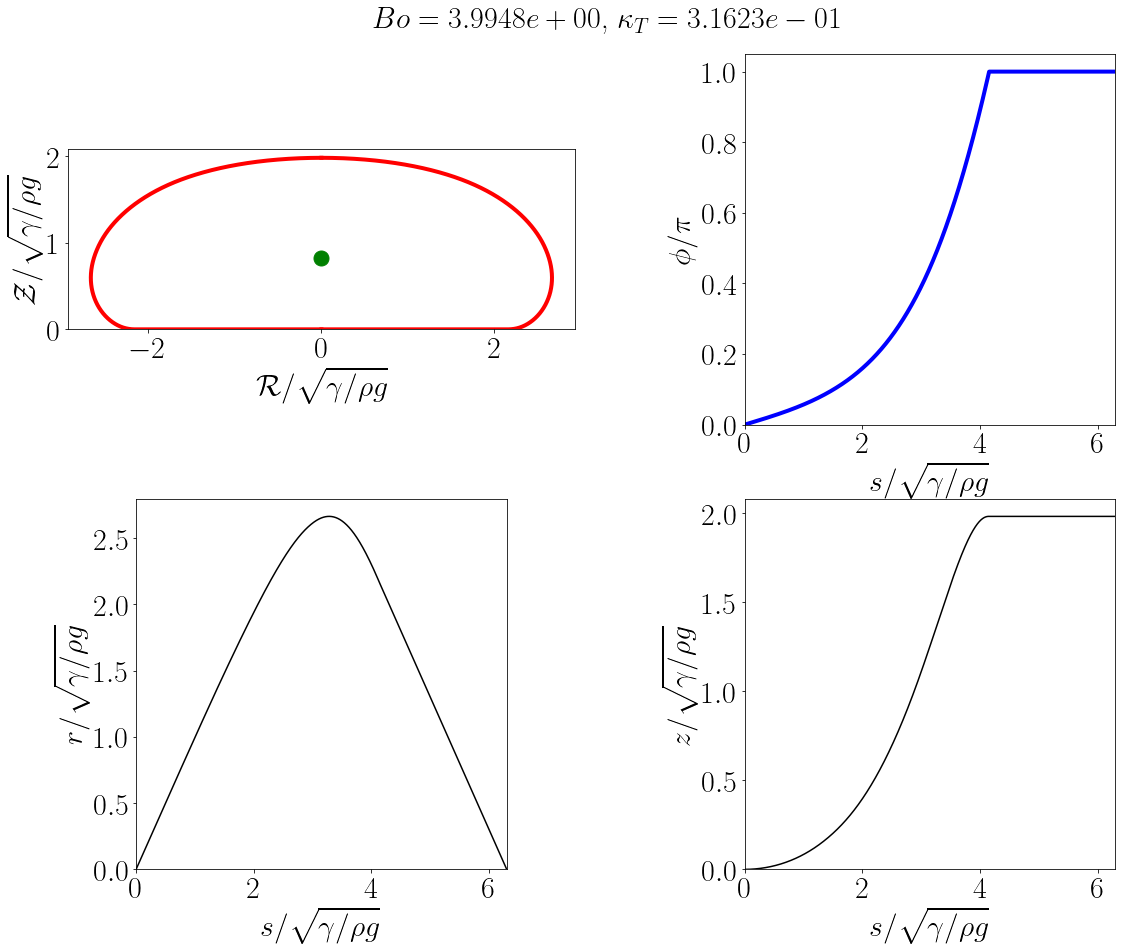

KappaT = 3.9811e-01
------------------------------------
Volume = 2.6700e+01
Perimeter = 5.7991e+00
Surface Area = 5.0287e+01
Bo = 3.4378e+00, H = 1.940, Zcm = 0.810, W = 2.415, Rw = 1.905
------------------------------------


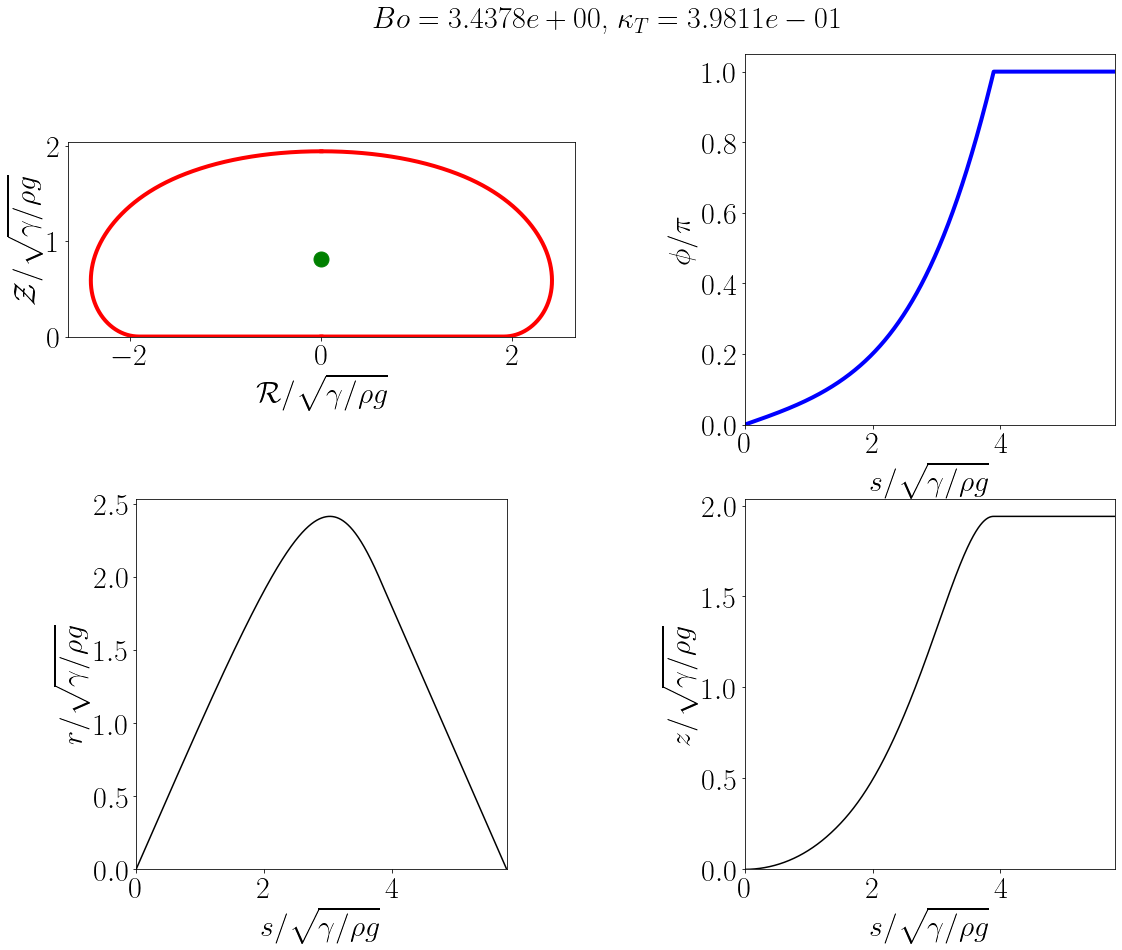

KappaT = 5.0119e-01
------------------------------------
Volume = 2.0809e+01
Perimeter = 5.2971e+00
Surface Area = 4.1623e+01
Bo = 2.9114e+00, H = 1.888, Zcm = 0.789, W = 2.168, Rw = 1.667
------------------------------------


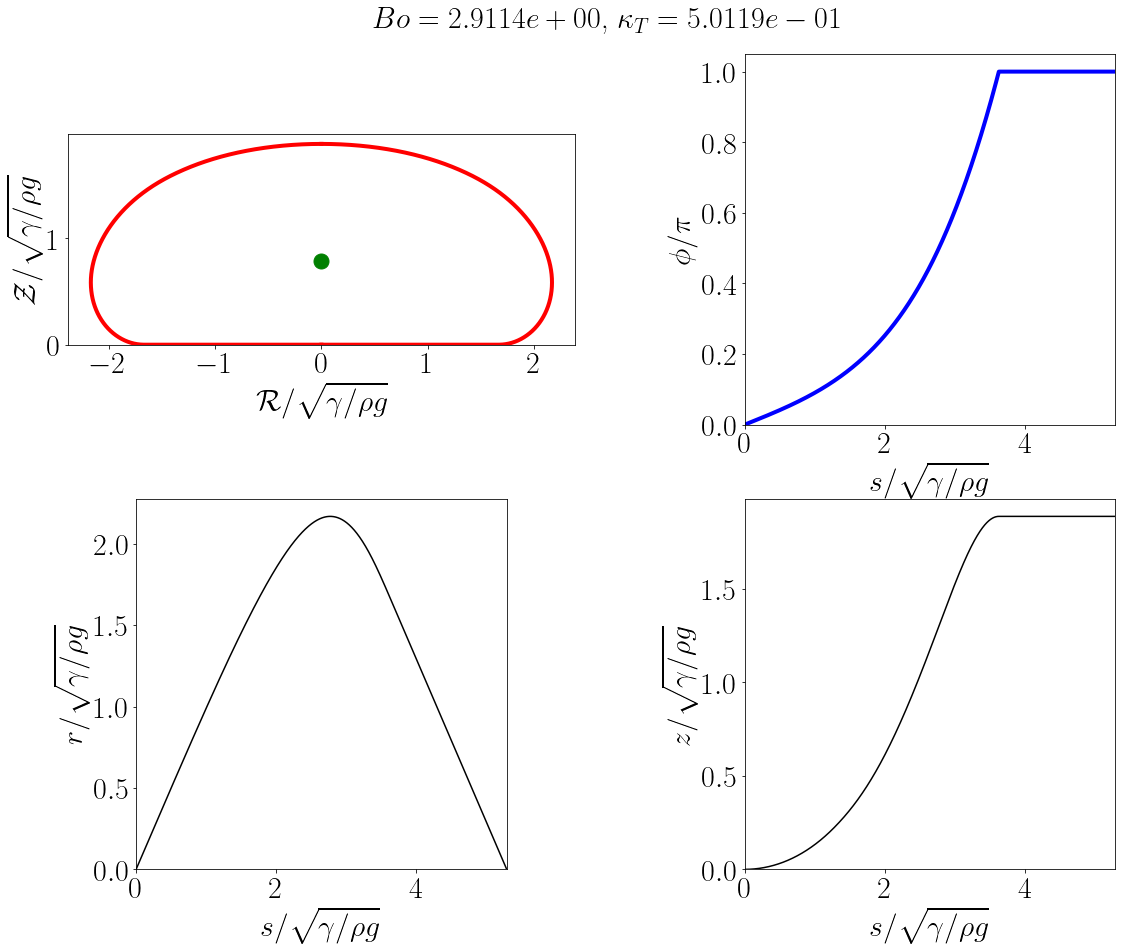

KappaT = 6.3096e-01
------------------------------------
Volume = 1.5761e+01
Perimeter = 4.7960e+00
Surface Area = 3.3816e+01
Bo = 2.4192e+00, H = 1.822, Zcm = 0.764, W = 1.925, Rw = 1.431
------------------------------------


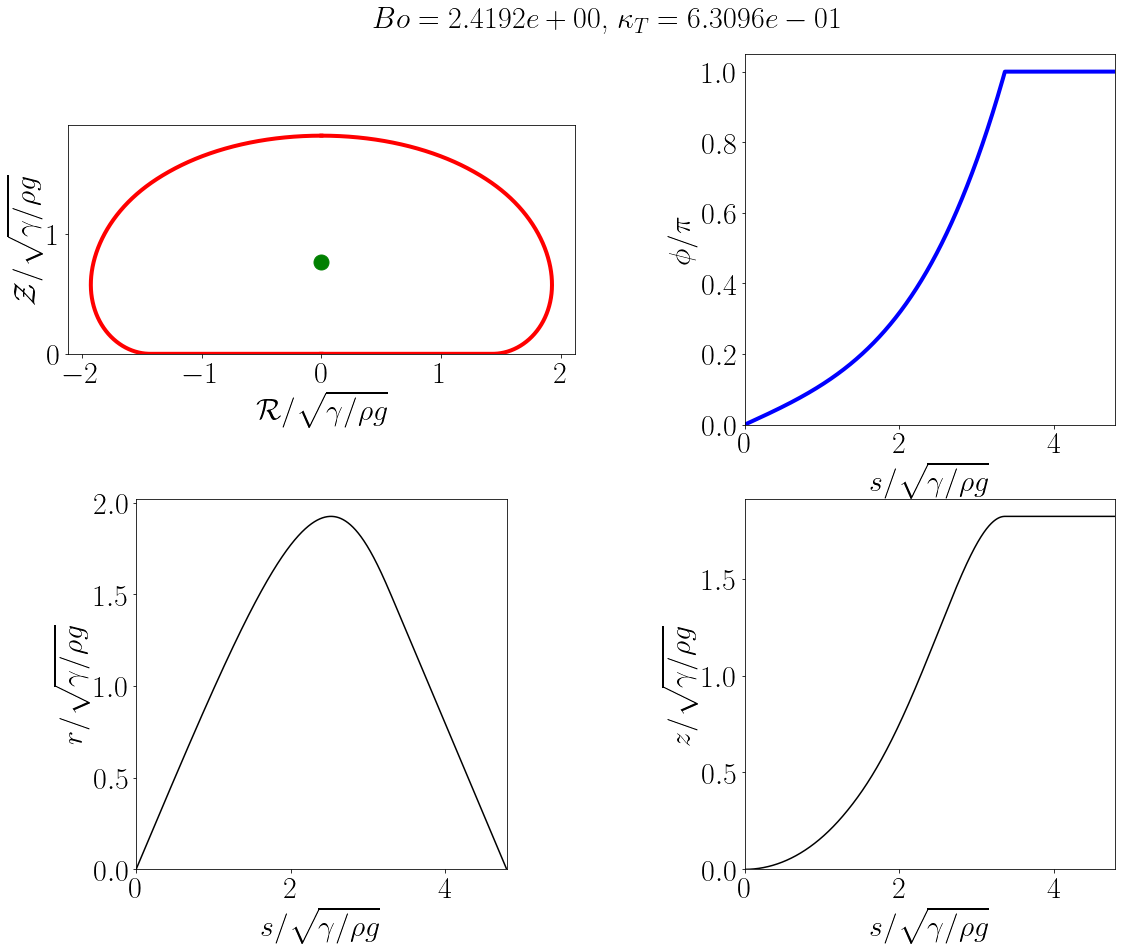

KappaT = 7.9433e-01
------------------------------------
Volume = 1.1560e+01
Perimeter = 4.3020e+00
Surface Area = 2.6929e+01
Bo = 1.9674e+00, H = 1.740, Zcm = 0.734, W = 1.690, Rw = 1.204
------------------------------------


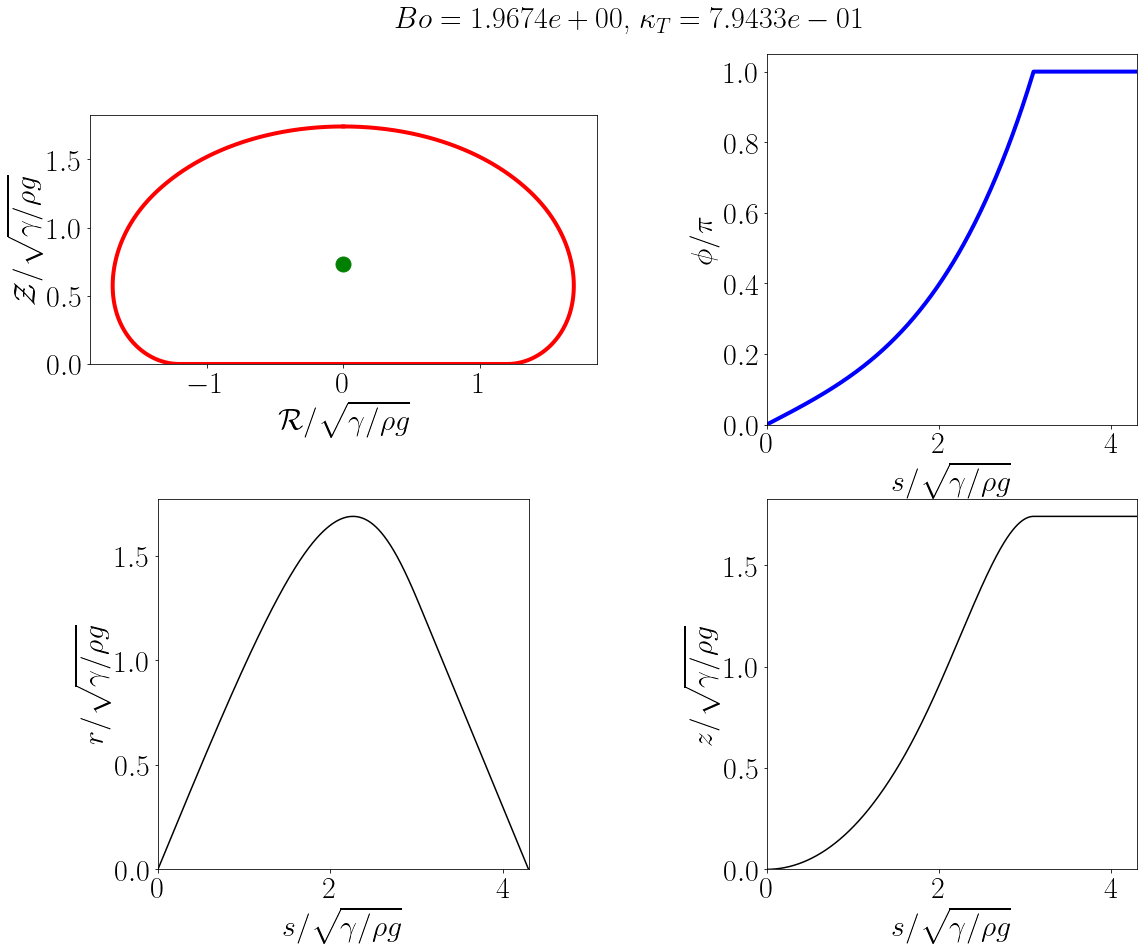

KappaT = 1.0000e+00
------------------------------------
Volume = 8.1761e+00
Perimeter = 3.8165e+00
Surface Area = 2.0959e+01
Bo = 1.5618e+00, H = 1.643, Zcm = 0.699, W = 1.468, Rw = 0.990
------------------------------------


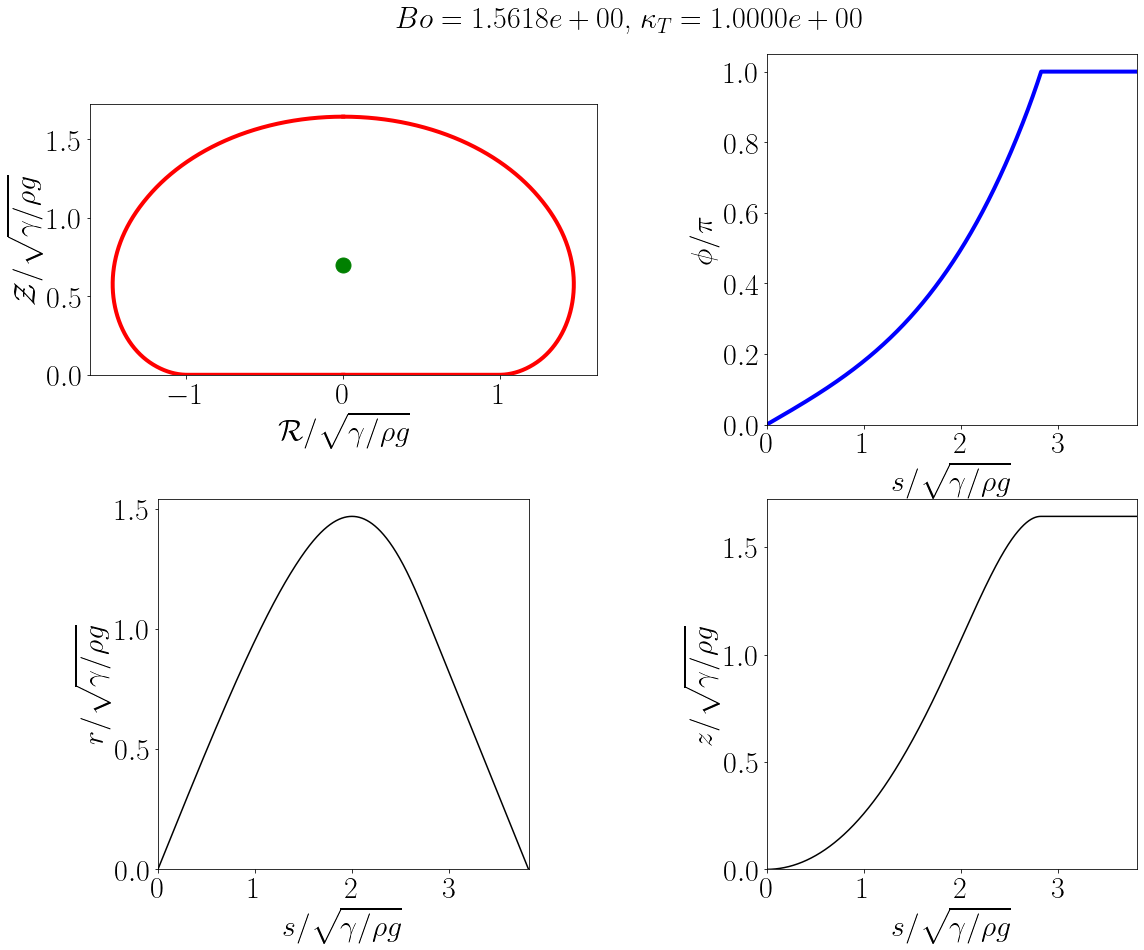

KappaT = 1.2589e+00
------------------------------------
Volume = 5.5660e+00
Perimeter = 3.3535e+00
Surface Area = 1.5965e+01
Bo = 1.2087e+00, H = 1.530, Zcm = 0.657, W = 1.258, Rw = 0.797
------------------------------------


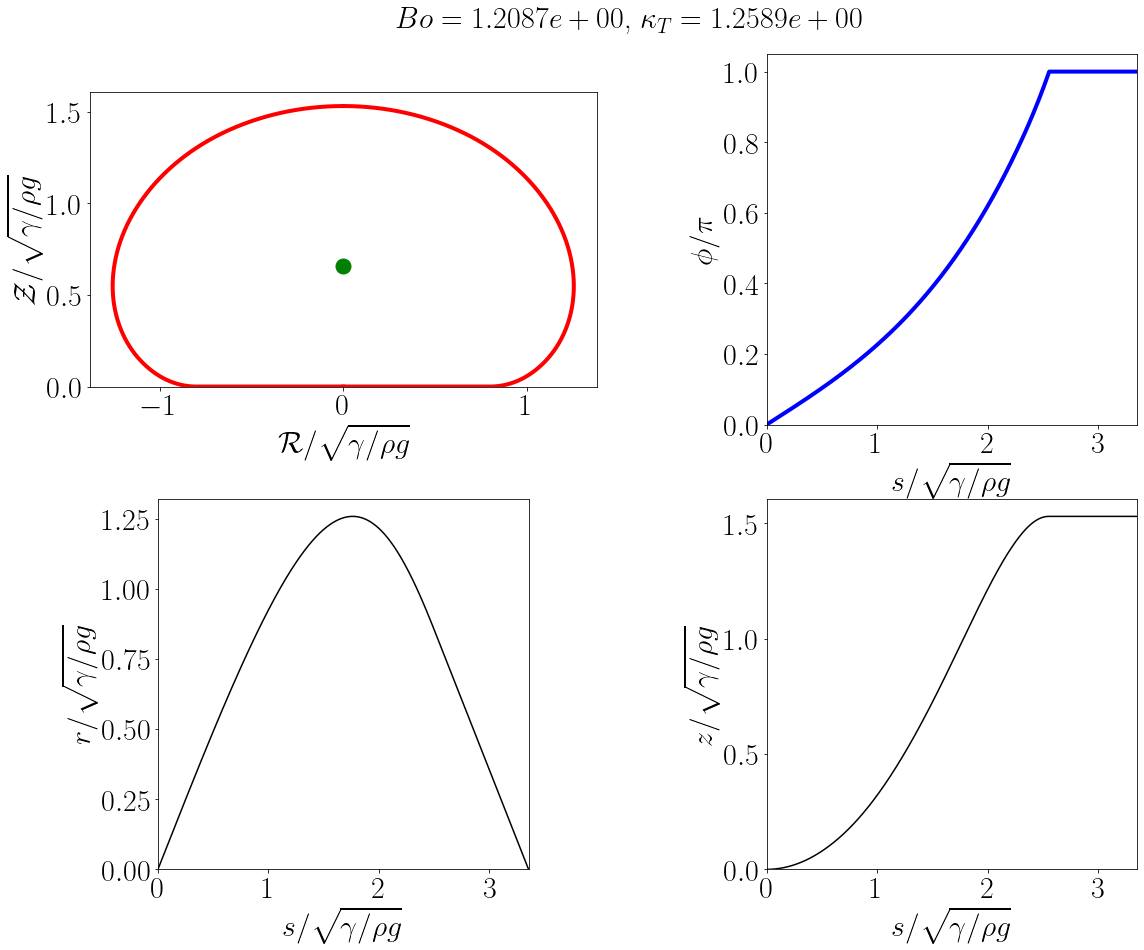

KappaT = 1.5849e+00
------------------------------------
Volume = 3.6283e+00
Perimeter = 2.9068e+00
Surface Area = 1.1830e+01
Bo = 9.0868e-01, H = 1.404, Zcm = 0.611, W = 1.063, Rw = 0.622
------------------------------------


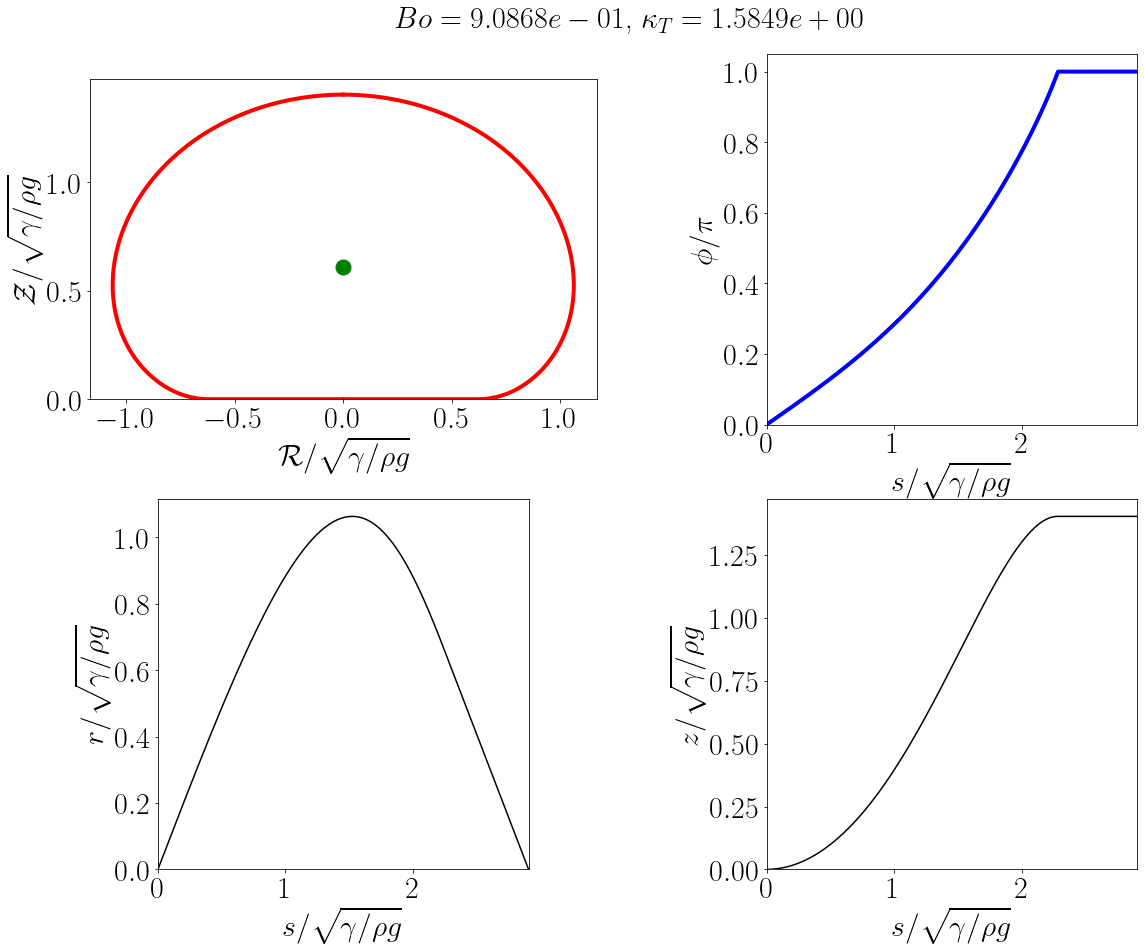

KappaT = 1.9953e+00
------------------------------------
Volume = 2.2632e+00
Perimeter = 2.4874e+00
Surface Area = 8.5362e+00
Bo = 6.6338e-01, H = 1.266, Zcm = 0.560, W = 0.887, Rw = 0.470
------------------------------------


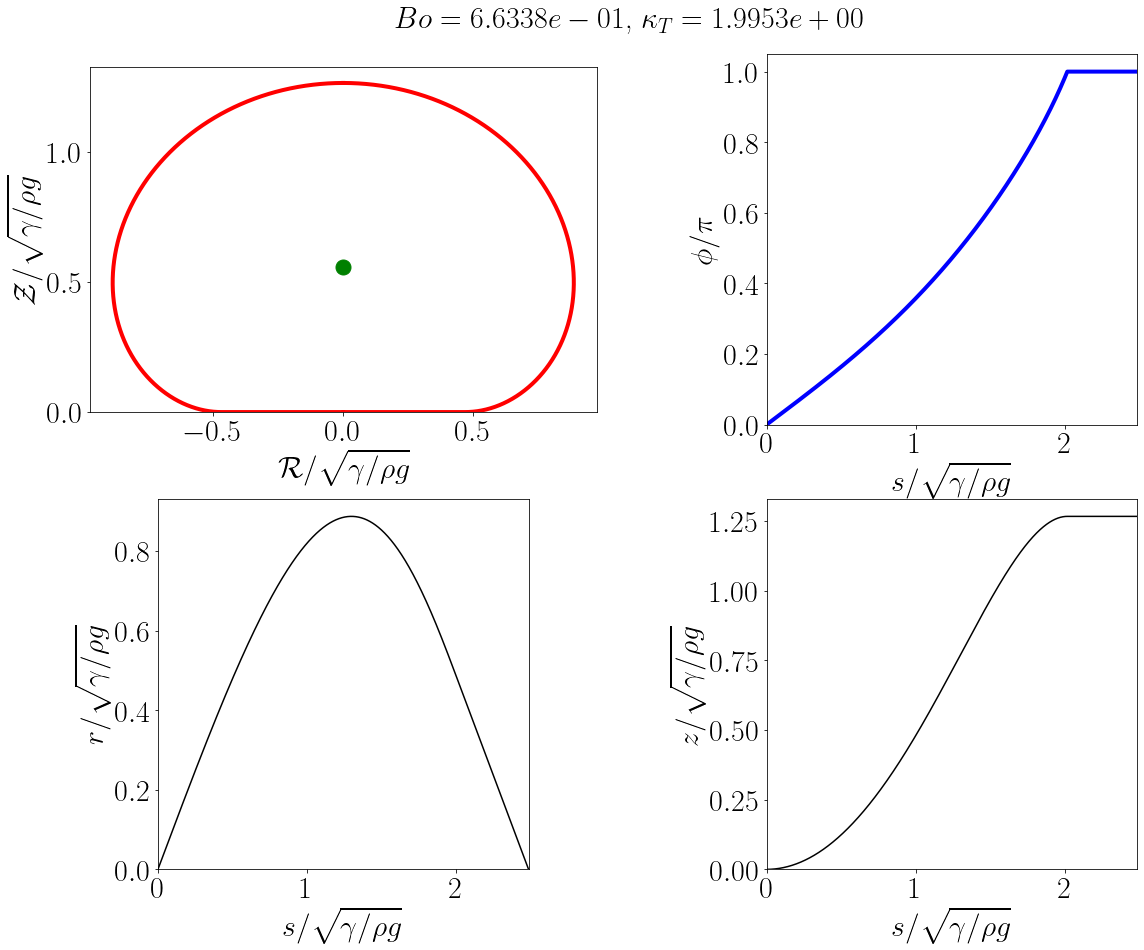

KappaT = 2.5119e+00
------------------------------------
Volume = 1.3527e+00
Perimeter = 2.1008e+00
Surface Area = 6.0016e+00
Bo = 4.7069e-01, H = 1.121, Zcm = 0.504, W = 0.731, Rw = 0.344
------------------------------------


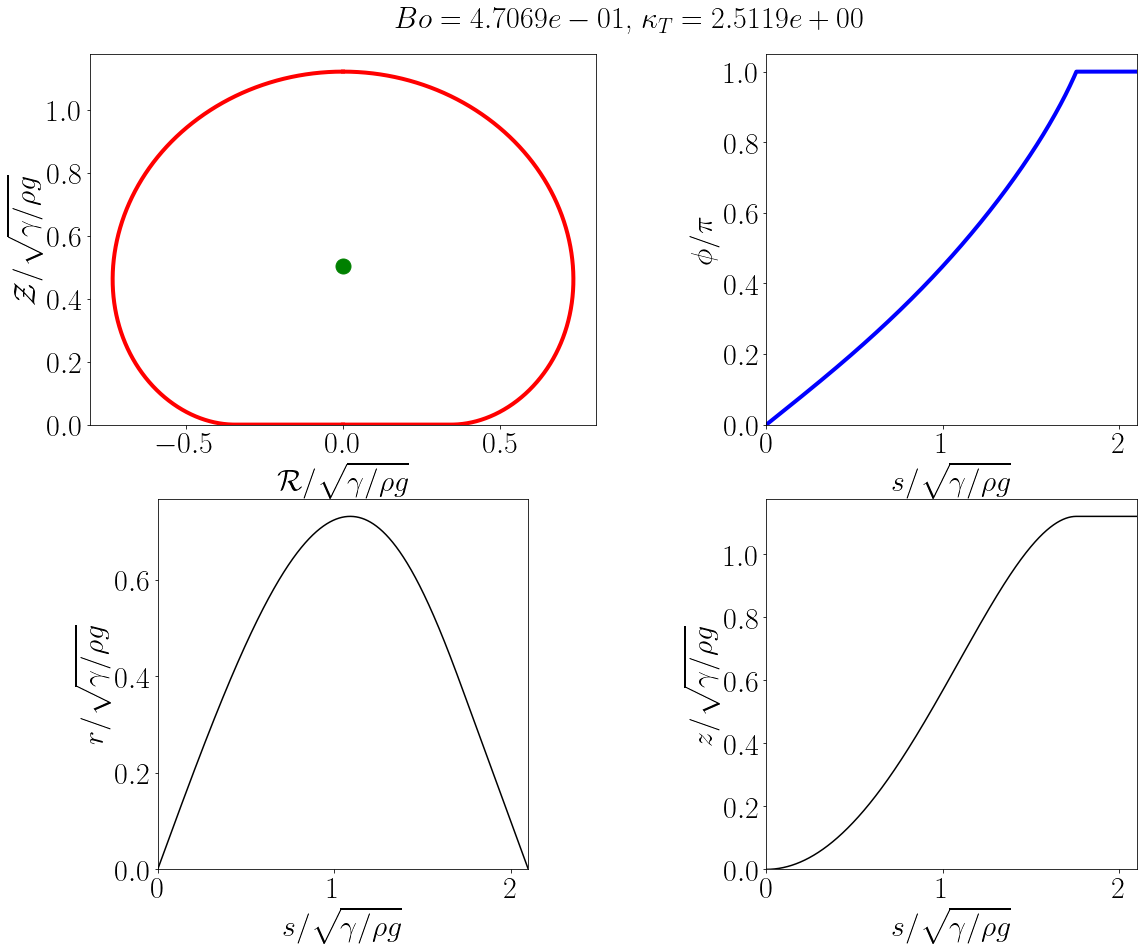

KappaT = 3.1623e+00
------------------------------------
Volume = 7.7580e-01
Perimeter = 1.7508e+00
Surface Area = 4.1154e+00
Bo = 3.2492e-01, H = 0.971, Zcm = 0.444, W = 0.598, Rw = 0.248
------------------------------------


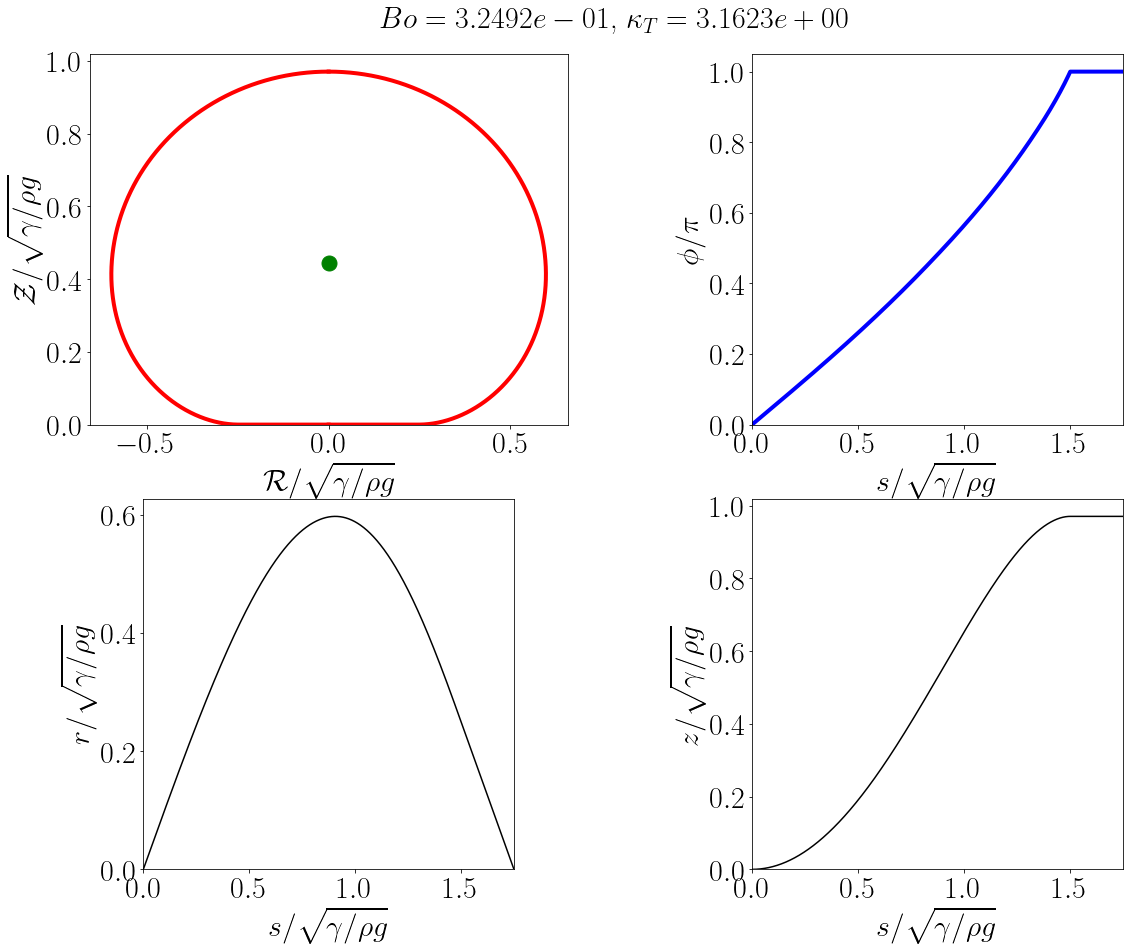

KappaT = 3.9811e+00
------------------------------------
Volume = 4.2973e-01
Perimeter = 1.4442e+00
Surface Area = 2.7647e+00
Bo = 2.1915e-01, H = 0.829, Zcm = 0.386, W = 0.484, Rw = 0.170
------------------------------------


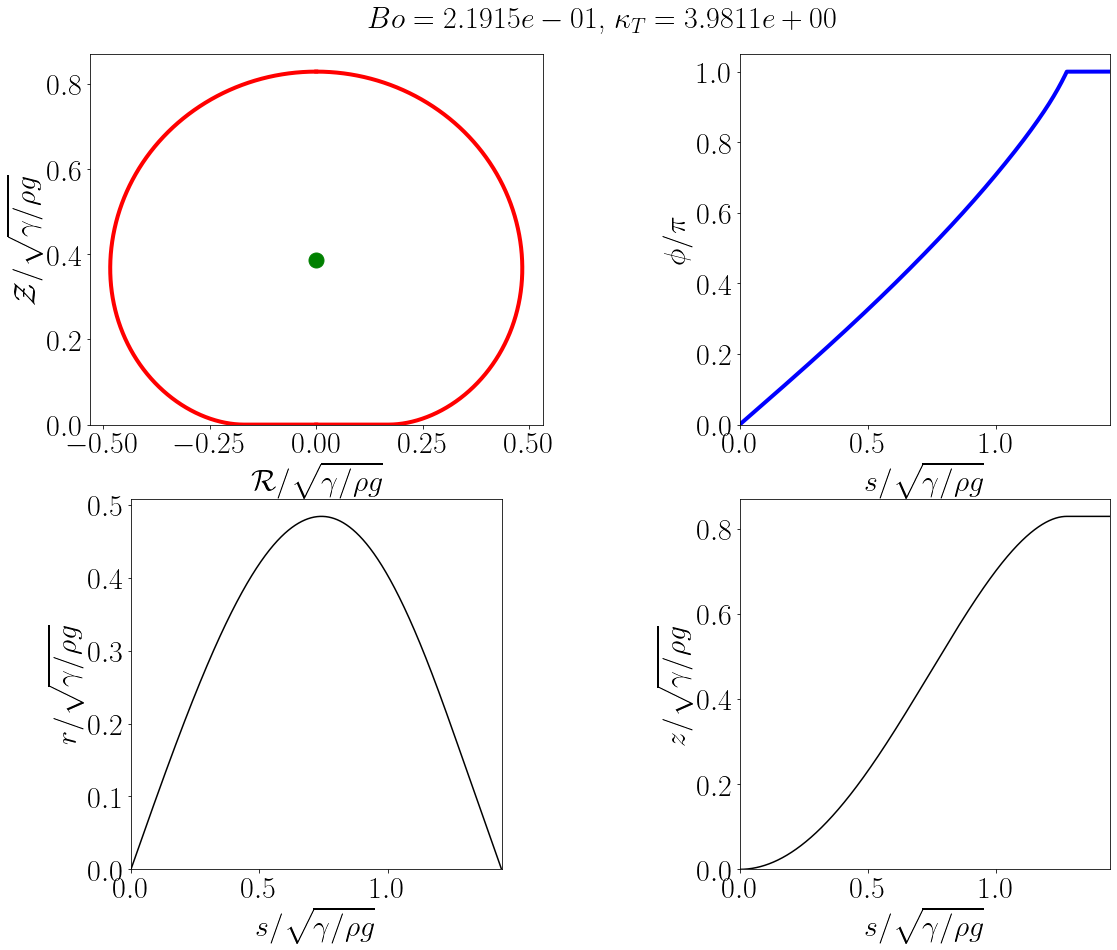

KappaT = 5.0119e+00
------------------------------------
Volume = 2.3127e-01
Perimeter = 1.1795e+00
Surface Area = 1.8250e+00
Bo = 1.4500e-01, H = 0.696, Zcm = 0.329, W = 0.390, Rw = 0.114
------------------------------------


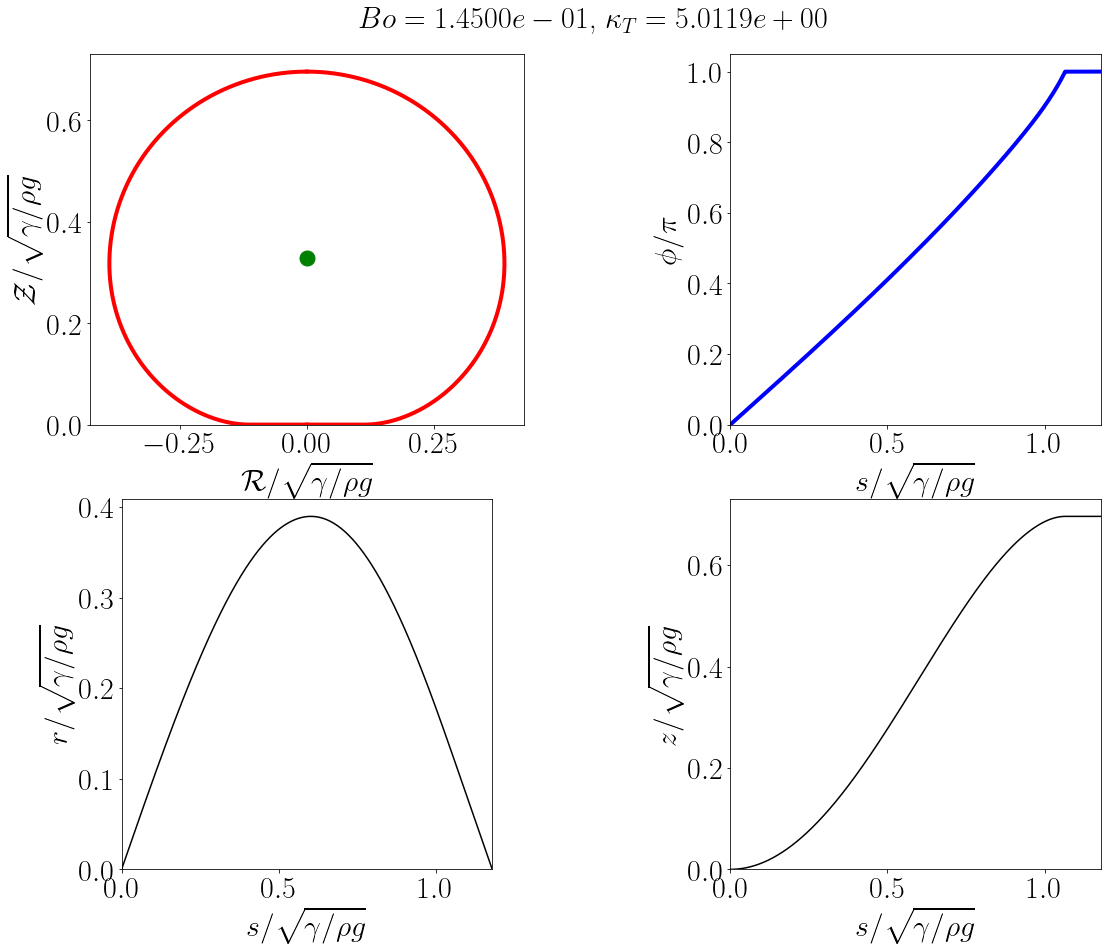

KappaT = 6.3096e+00
------------------------------------
Volume = 1.2174e-01
Perimeter = 9.5571e-01
Surface Area = 1.1882e+00
Bo = 9.4531e-02, H = 0.576, Zcm = 0.276, W = 0.312, Rw = 0.075
------------------------------------


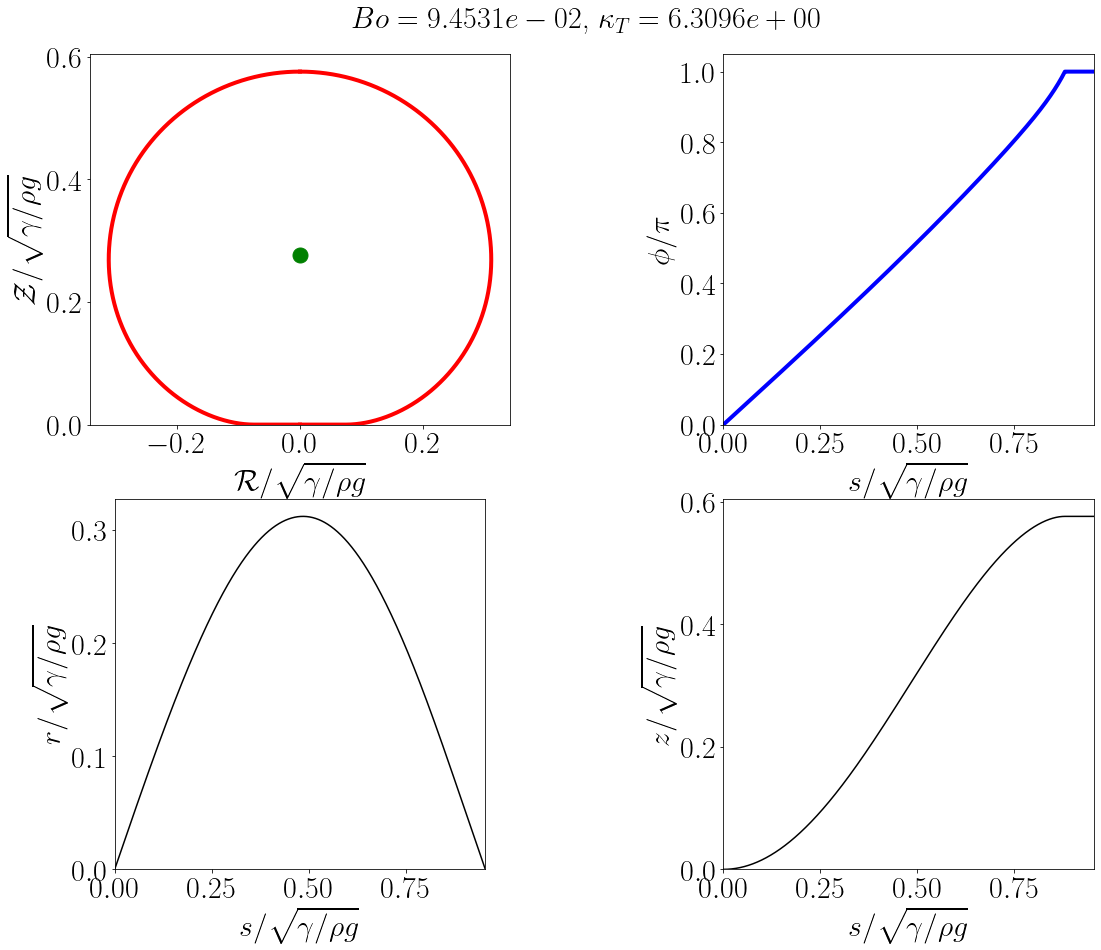

KappaT = 7.9433e+00
------------------------------------
Volume = 6.3062e-02
Perimeter = 7.6967e-01
Surface Area = 7.6580e-01
Bo = 6.0970e-02, H = 0.471, Zcm = 0.228, W = 0.249, Rw = 0.049
------------------------------------


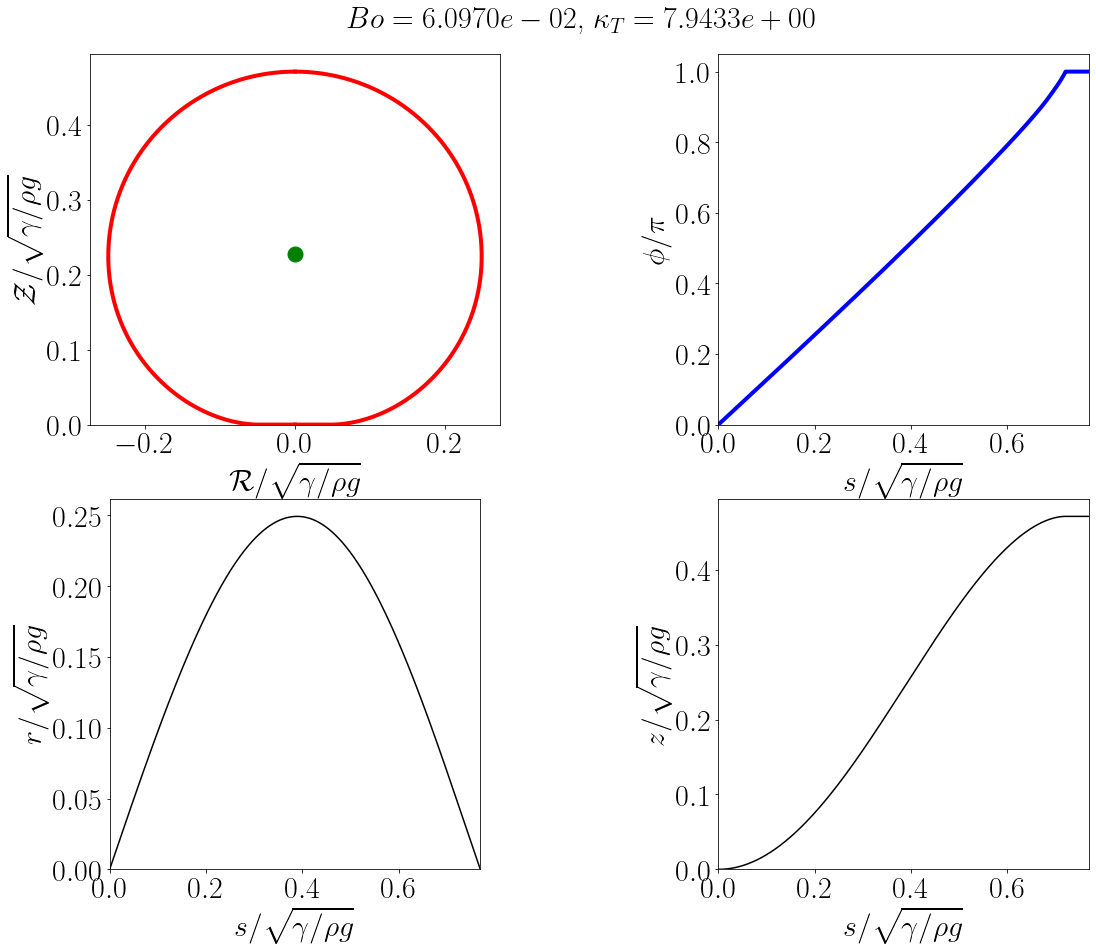

KappaT = 1.0000e+01
------------------------------------
Volume = 3.2299e-02
Perimeter = 6.1711e-01
Surface Area = 4.9004e-01
Bo = 3.9030e-02, H = 0.382, Zcm = 0.187, W = 0.199, Rw = 0.032
------------------------------------


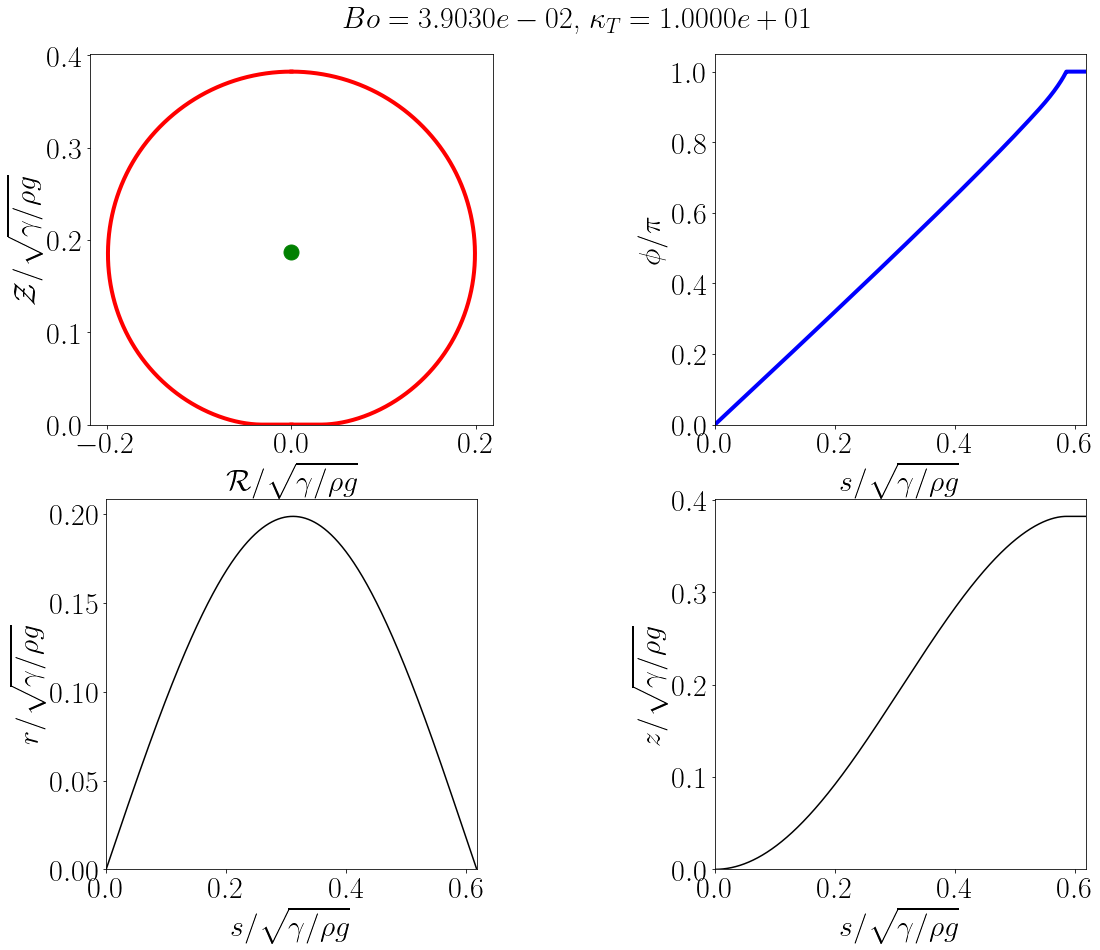

KappaT = 1.2589e+01
------------------------------------
Volume = 1.6417e-02
Perimeter = 4.9323e-01
Surface Area = 3.1205e-01
Bo = 2.4858e-02, H = 0.308, Zcm = 0.151, W = 0.158, Rw = 0.021
------------------------------------


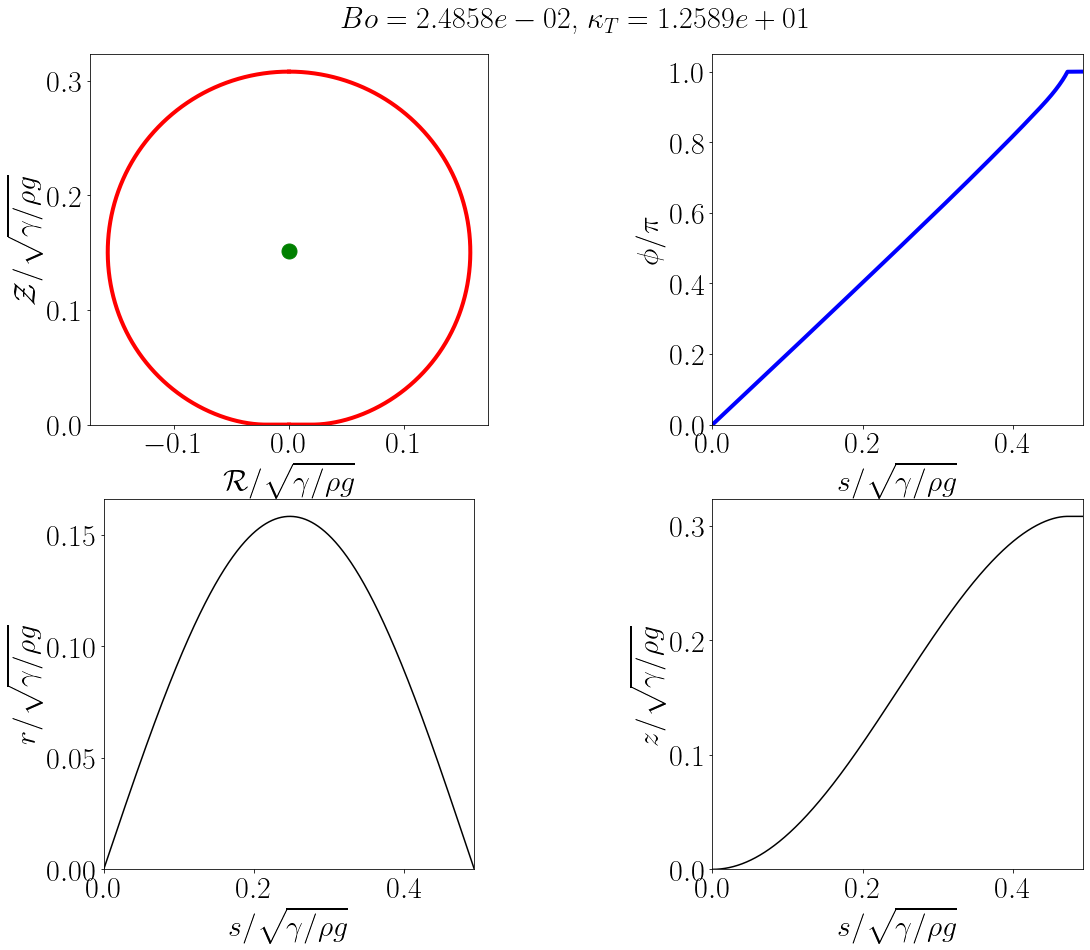

KappaT = 1.5849e+01
------------------------------------
Volume = 8.3027e-03
Perimeter = 3.9340e-01
Surface Area = 1.9806e-01
Bo = 1.5779e-02, H = 0.247, Zcm = 0.122, W = 0.126, Rw = 0.013
------------------------------------


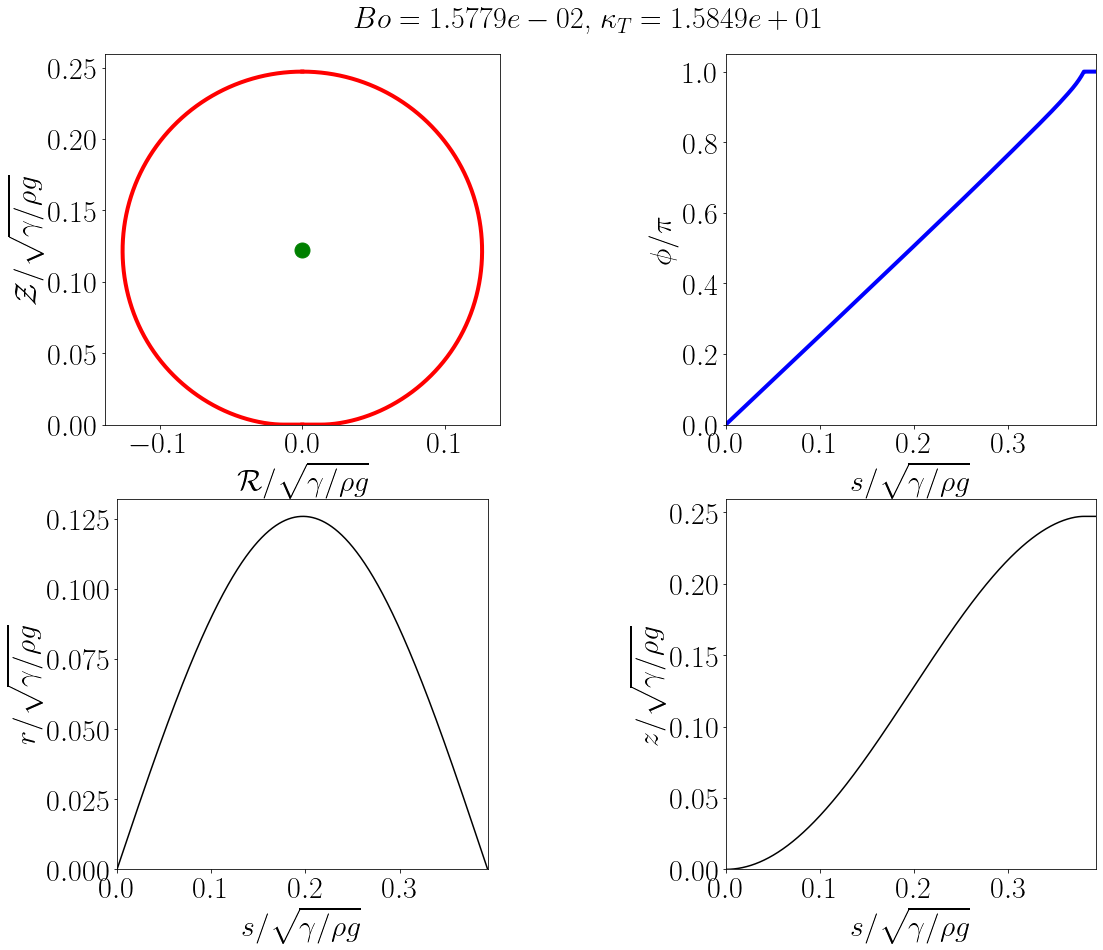

KappaT = 1.9953e+01
------------------------------------
Volume = 4.1853e-03
Perimeter = 3.1331e-01
Surface Area = 1.2545e-01
Bo = 9.9944e-03, H = 0.198, Zcm = 0.098, W = 0.100, Rw = 0.009
------------------------------------


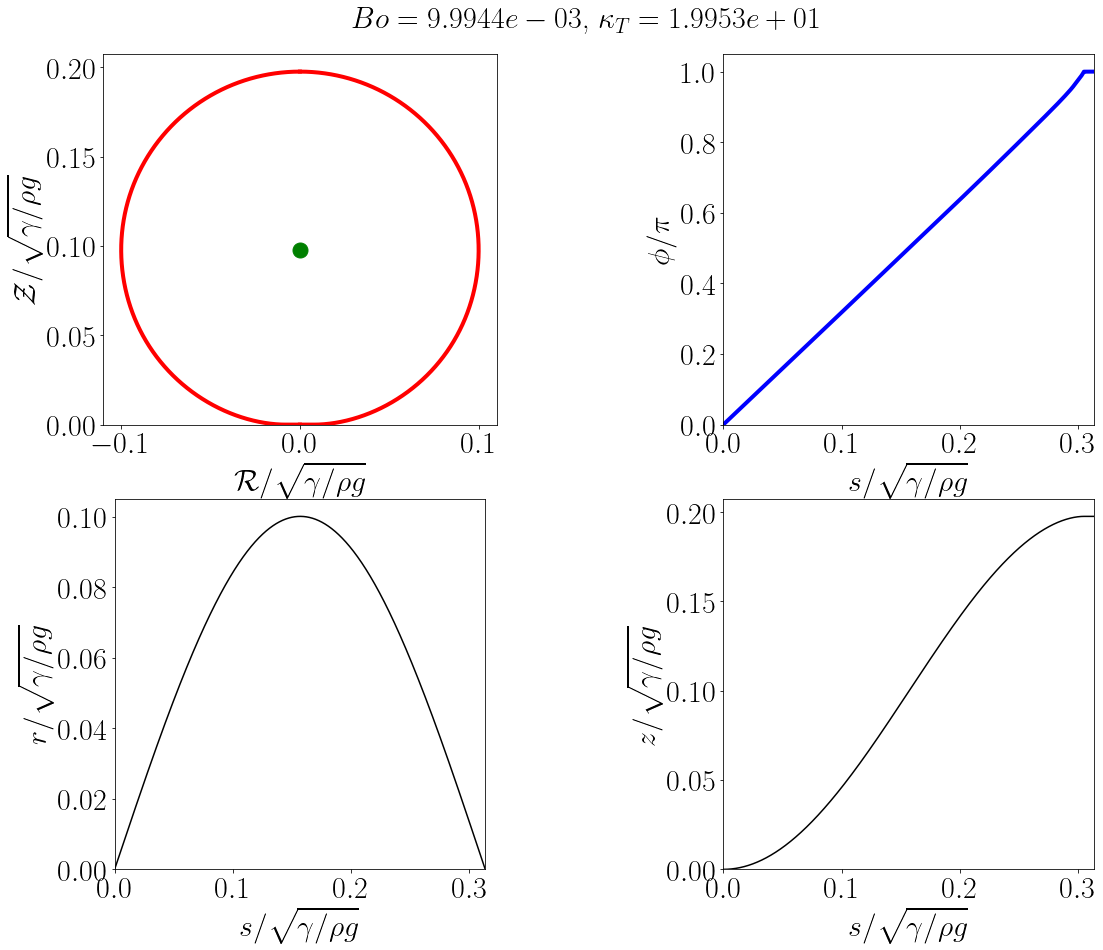

KappaT = 2.5119e+01
------------------------------------
Volume = 2.1053e-03
Perimeter = 2.4930e-01
Surface Area = 7.9343e-02
Bo = 6.3215e-03, H = 0.158, Zcm = 0.078, W = 0.080, Rw = 0.006
------------------------------------


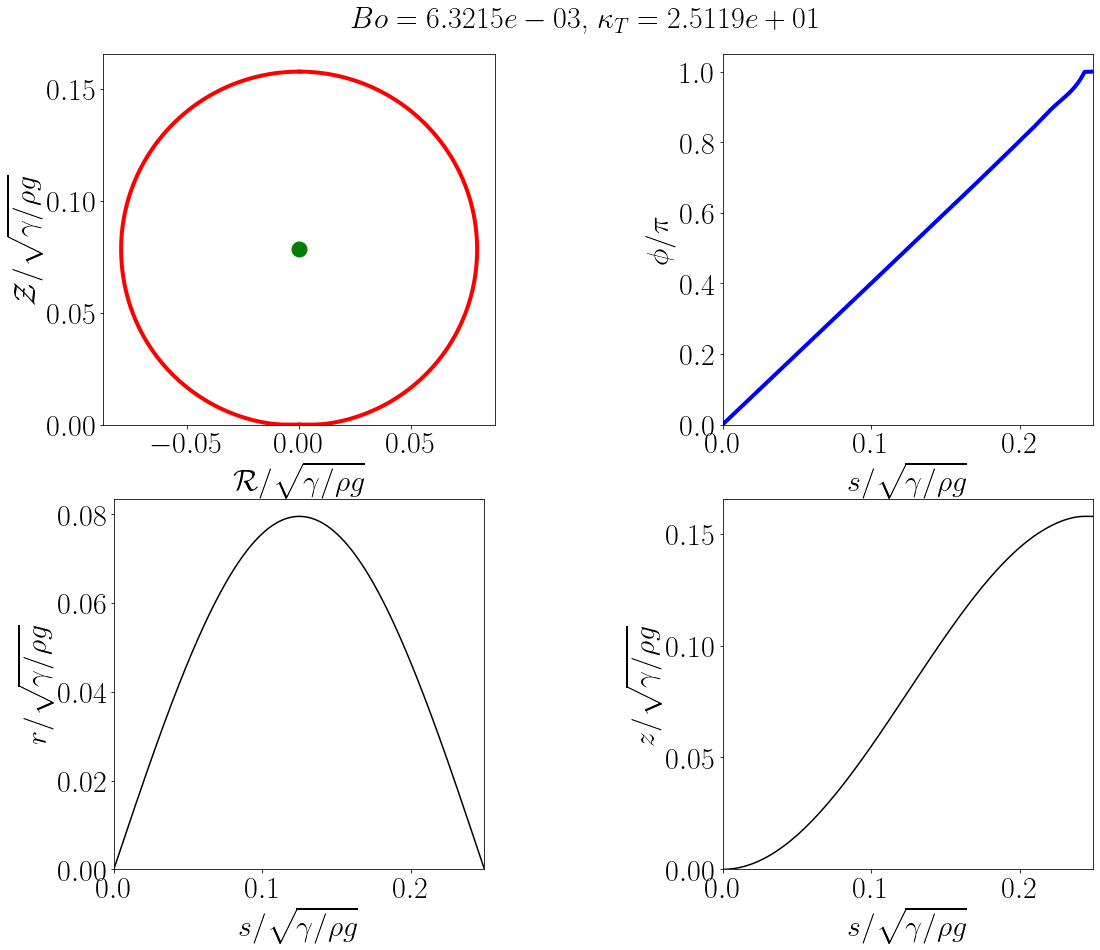

KappaT = 3.1623e+01
------------------------------------
Volume = 1.0574e-03
Perimeter = 1.9819e-01
Surface Area = 5.0141e-02
Bo = 3.9944e-03, H = 0.126, Zcm = 0.063, W = 0.063, Rw = 0.001
------------------------------------


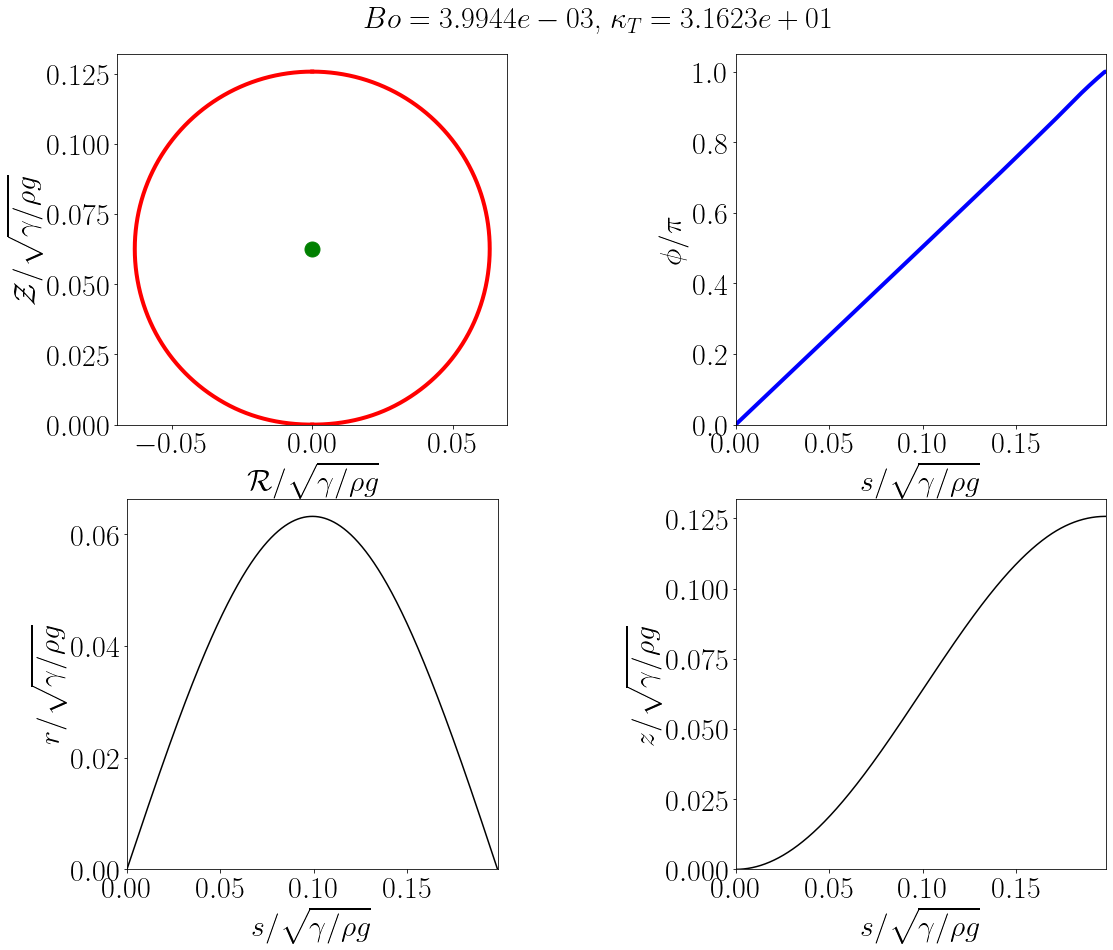

KappaT = 1.0000e+02
------------------------------------
Volume = 3.3570e-05
Perimeter = 6.2797e-02
Surface Area = 5.0263e-03
Bo = 4.0047e-04, H = 0.040, Zcm = 0.020, W = 0.020, Rw = 0.001
------------------------------------


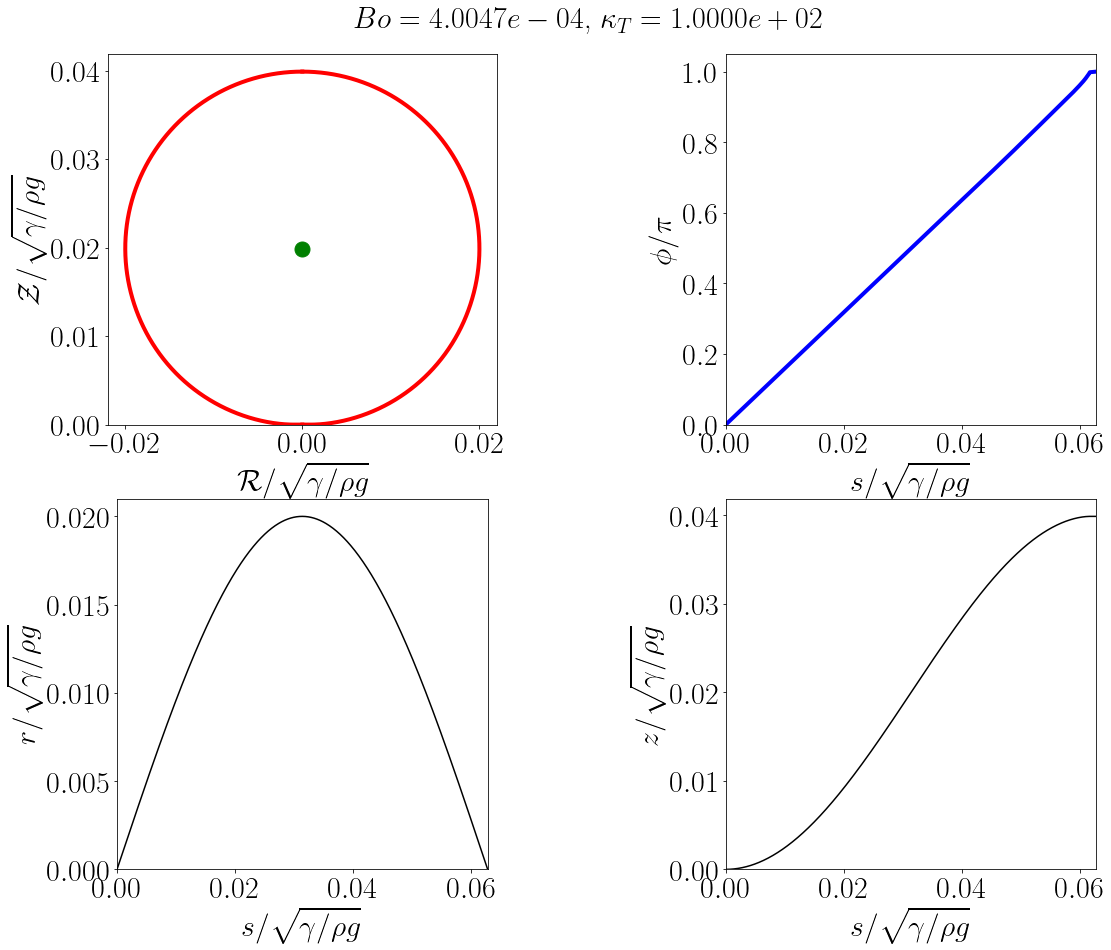

KappaT = 1.0000e+03
------------------------------------
Volume = 3.3595e-08
Perimeter = 6.2826e-03
Surface Area = 5.0280e-05
Bo = 4.0067e-06, H = 0.004, Zcm = 0.002, W = 0.002, Rw = 0.000
------------------------------------
KappaT = 1.0000e+04
------------------------------------
Volume = 3.2236e-11
Perimeter = 6.2852e-04
Surface Area = 4.9253e-07
Bo = 3.8979e-08, H = 0.000, Zcm = 0.000, W = 0.000, Rw = 0.000
------------------------------------


In [5]:
BoNorm = 1.0 # 1 because we normalize using $L_0$ but I did not want to change the function from the previous notebook [SessileDrop.ipynb](SessileDrop.ipynb)
# curvature at the top of the drop: this is the input parameter
# KappaT = arange(1.4707963267949, 2, 1)
KappaT = 10**arange(-30.0, -5.0, 5.0)
temp = 10**arange(-5.0, -2.0, 1.0)
KappaT = append(KappaT, temp)
temp = 10**arange(-2.0, -1.5, 0.5)
KappaT = append(KappaT, temp)
temp = 10**arange(-1.5, 0.0, 0.1)
KappaT = append(KappaT, temp)
temp = 10**arange(0.0, 1.5, 0.1)
KappaT = append(KappaT, temp)
temp = 10**arange(1.5, 2.0, 0.5)
KappaT = append(KappaT, temp)
temp = 10**arange(2.0, 3.0, 1.0)
KappaT = append(KappaT, temp)
temp = 10**arange(3.0, 5.0, 1.0)
KappaT = append(KappaT, temp)

# Plot is true of KappaT is between 1e-2 and 1e2
Plot = zeros_like(KappaT)
Plot[where((KappaT>=1e-2) & (KappaT<=1e2))] = 1
Plot = Plot.astype(bool)

Bond = zeros_like(KappaT)
Height = zeros_like(KappaT)
Zcm = zeros_like(KappaT)
Width = zeros_like(KappaT)
Rfoot = zeros_like(KappaT)
Perimeter = zeros_like(KappaT)
SurfaceArea = zeros_like(KappaT)


folder='NormalizeBond'
if not os.path.exists(folder):
    os.makedirs(folder)

folder='NormalizeBond/Images'
if not os.path.exists(folder):
    os.makedirs(folder)


for kappa in KappaT:
    print('KappaT = %5.4e' % kappa)
    sol = getDrop(BoNorm, kappa)
    S, Phi, r, z = sol.t, sol.y[0], sol.y[1], sol.y[2]
    # coordinate transformation to have drop straight up
    Z = -z+z[-1]
    R = r
    Rfoot[where(KappaT==kappa)] = R[-1]
    # join a straight line from the last point to the origin
    Z = append(Z, 0.0)
    R = append(R, 0.0)
    S = append(S, S[-1]+r[-1])
    r = append(r, 0.0)
    z = append(z, z[-1])
    Phi = append(Phi, pi)
    
    # width and height of the drop
    Height[where(KappaT==kappa)] = Z.max()
    Width[where(KappaT==kappa)] = R.max()
    # center of mass
    Zcm[where(KappaT==kappa)] = centerOfMass(R, Z)
    # Volume of the drop
    Vol = volume(R, Z)        
    # Perimeter of the drop
    Perimeter[where(KappaT==kappa)] = S[-1]
    # Surface area of the drop
    SurfaceArea[where(KappaT==kappa)] = surface(R, Z, S)
    print('------------------------------------')
    print('Volume = %5.4e' % Vol)
    print('Perimeter = %5.4e' % Perimeter[where(KappaT==kappa)])
    print('Surface Area = %5.4e' % SurfaceArea[where(KappaT==kappa)])

    # the actual Bond number
    BoTrue = (3*Vol/(4*pi))**(2.0/3.0)
    Bond[where(KappaT==kappa)] = BoTrue

    print('Bo = %5.4e, H = %4.3f, Zcm = %4.3f, W = %4.3f, Rw = %4.3f' % (BoTrue, float(Height[where(KappaT==kappa)]), float(Zcm[where(KappaT==kappa)]), float(Width[where(KappaT==kappa)]), float(Rfoot[where(KappaT==kappa)])))
    print('------------------------------------')

    if Plot[where(KappaT==kappa)]:
        filename = 'NormalizeBond/Images/NormalizeBond_KappaT_%5.4f_Bond_%5.4f.png' % (kappa, BoTrue)
        Plotting(R, Z, S, Phi, r, z, filename, BoTrue, kappa, Zcm[where(KappaT==kappa)])

data = {'KappaT': KappaT, 'Bond': Bond, 'Height': Height, 'Zcm': Zcm, 'Width': Width, 'Rfoot': Rfoot, 'Perimeter': Perimeter, 'SurfaceArea': SurfaceArea}
df = pd.DataFrame(data)
df.to_csv('NormalizeBond/NormalizeBond_v2.csv', index=False)